# AuxLoss

Note: workflow has been adapted from the example at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
<br>The dataset is imported from the master files already split on paired images, AP images, and L images.
<br>A dataset object is setup to preprocess and augment images, the model is defined with DenseNet121 models as a backbone, then the model is trained and tested with and without augmentations for both the anterior and posterior datasets.
<br> Once it is selected as the better performing model (and once it is established that augmented performs better than non-augmented), the model's hyperparameters are tuned using a random search while iterating on the anterior dataset (six iterations). Before settling on which hyperparameters to tune, many other experiments were run such as different optimizers (like SGD with and without momentum) and different ways of stepping the optimizer.
<br> The model is then trained and tested on three random splits of the anterior and posterior datasets to calculate the statistical significance of its performance metrics.

## Import required libraries

In [1]:
import sys  
sys.path.insert(0, '../')
import tqdm
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import lr_scheduler
import time
import copy
import cv2
import sys  
sys.path.insert(0, '../../workspace/')
sys.path.insert(0, '../utilities/')
import os, os.path as osp
import pandas as pd
import pydicom
import json
import re
import pickle
import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
import preprocessing_function
import metrics
from utilities import helper_functions, splitting, augmentations
from PIL import Image
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 400)

## Define Dataset

In [2]:
class ViewsDataset(Dataset):
    
    def __init__(self, img_paths, labels, augmentation_function, png=True):
        '''
        Initialize the dataset with image paths, their corresponding Y labels (in numpy format)
        '''        
        self.img_files = img_paths
        self.labels = labels
        self.augmentation = augmentation_function
        self.png = png
        
    def load_png(self, img_path):
        '''
        This function loads an image from a PNG path
        '''
        try:
            if img_path is not np.nan:
                actual_image = cv2.imread(img_path)
            else:
                actual_image = np.zeros((3,256,256)).astype(np.uint8)
        except:
            actual_image = np.zeros((3,256,256)).astype(np.uint8)
        
        actual_image = Image.fromarray(actual_image, mode="RGB")
        
        return actual_image
    
    def load_dicom(self, img_path):
        '''
        This function loads an image from a DICOM path. If there is an error with the path, it will print error and 
        return a 256x256 array of zeros
        '''
        try:
            image_info = pydicom.dcmread(img_path)
            actual_image = image_info.pixel_array
            
        except:
            actual_image = np.zeros((256,256))
        
        actual_image = helper_functions.prepare_image(actual_image, rgb=True, channels_first=True)
        
        if self.augmentation is not None:
            actual_image = Image.fromarray(actual_image, mode="RGB")
        else:
            actual_image = torch.as_tensor(actual_image/255.)

        return actual_image
    
    def __getitem__(self, index):
        '''
        Get a unique item from the dataset according to index. This is required when building a custom dataloader
        '''
        img_row = self.img_files.iloc[index,:]
        
        if (self.png):
            AP_view = self.load_png(img_row.filepath_AP)
            L_view = self.load_png(img_row.filepath_L)
        else:
            AP_view = self.load_dicom(img_row.filepath_AP)
            L_view = self.load_dicom(img_row.filepath_L)
        
        if self.augmentation is not None:
            AP_view = self.augmentation(AP_view)
            L_view = self.augmentation(L_view)
        
        Y = self.labels[index]
        
        return (AP_view.float(), L_view.float()), torch.as_tensor(Y).long()
        
    
    def __len__(self):
        '''
        Length of the dataset. This is required when building a custom dataloader
        '''
        return len(self.img_files)

## Define AuxLoss Model

In [3]:
class AuxLossModel(nn.Module):

    def __init__(self, AP_model, L_model, num_classes, dropout_AuxLoss, dropout_AP, dropout_L):
        
        super(AuxLossModel, self).__init__()
        
        # AP_model is a DenseNet-121 model used to process AP views when L view unavailable        
        self.AP_model = AP_model
        # L_model is a DenseNet-121 model used to process L views when AP view unavailable
        self.L_model = L_model
        
        # take AP_model and L_model until after their third dense blocks for use in the AuxLoss model
        for count, child in enumerate(self.AP_model.named_children()):
            if (count==0):
                self.AP_blocks = child[1][0:10]
        for count, child in enumerate(self.L_model.named_children()):
            if (count==0):
                self.L_blocks = child[1][0:10]
        
        self.dropout_AuxLoss = nn.Dropout(p=dropout_AuxLoss)
        self.dropout_AP = nn.Dropout(p=dropout_AP)
        self.dropout_L = nn.Dropout(p=dropout_L)
        
        # apply a fully connected layer after concat/mean of the first 3 dense blocks of the AP/L models 
        # 32768 is the flattened dimension after passing the image through the first 3 blocks of DenseNet-121 (512*8*8)
        self.fc_AuxLoss = nn.Linear(32768, num_classes)
        self.fc_AP = nn.Linear(num_classes, num_classes)
        self.fc_L = nn.Linear(num_classes, num_classes)
    
    def forward(self, x):
        '''
        Forward pass through the network
        '''
        x_AP = x[0]
        x_L = x[1]

        # if the AP input is all zeros, then proceed with the output from the L model    
        if(x_AP.cpu().numpy().any()==False):
            x = self.L_model(x_L)
            x = self.dropout_L(x)
            x = self.fc_L(x)
        # if the L input is all zeros, then proceed with the output from the AP model
        elif (x_L.cpu().numpy().any()==False):
            x = self.AP_model(x_AP)
            x = self.dropout_AP(x)
            x = self.fc_AP(x)
        # if the AP and L inputs are both present, use the output of the joint model
        else:
            for block in self.AP_blocks:
                x_AP = block(x_AP)
            for block in self.L_blocks:
                x_L = block(x_L)
            x_AP = torch.unsqueeze(x_AP,1)
            x_L = torch.unsqueeze(x_L,1)
            x = torch.cat([x_AP, x_L], dim=1)
            x = x.mean(dim=1) # returns dimension [1,batch_size,512,8,8]
            x = x.view(-1, 32768) # change dimension to [batch_size,512*8*8]
            x = self.dropout_AuxLoss(x)
            x = self.fc_AuxLoss(x) # change dimension to [32768,num_classes]

        return x 

## Define Training Function

In [4]:
def train_model(dataset_AuxLoss, dataset_AP, dataset_L, model, criterion_AuxLoss, criterion_AP, criterion_L, optimizer_AuxLoss, optimizer_AP, optimizer_L, scheduler_AuxLoss, scheduler_AP, scheduler_L, num_epochs, dataloaders_AuxLoss, dataloaders_AP, dataloaders_L):
    since = time.time()
    device = 'cuda:1'
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_epoch_loss_AP = []
    val_epoch_loss_AP = []
    train_epoch_loss_L = []
    val_epoch_loss_L = []
    train_epoch_loss_AuxLoss = []
    val_epoch_loss_AuxLoss = []
    
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode        
   
            running_loss_AP = 0.0
            running_corrects_AP = 0
            running_loss_L = 0.0
            running_corrects_L = 0
            running_loss_AuxLoss = 0.0
            running_corrects_AuxLoss = 0
            
            # Iterate over AP data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders_AP[phase]):
                inputs = list(map(lambda x:x.to(device),inputs))
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer_AP.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # no L image
                        loss_AP = criterion_AP(outputs, labels)
                        loss_AP.backward()
                        optimizer_AP.step() 
                    
                running_loss_AP += loss_AP.item() * inputs[0].size(0)
                running_corrects_AP += torch.sum(preds == labels.data)
                
            # Iterate over L data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders_L[phase]):
                inputs = list(map(lambda x:x.to(device),inputs))
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer_L.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_L = criterion_L(outputs, labels)
                        loss_L.backward()
                        optimizer_L.step()
                
                running_loss_L += loss_L.item() * inputs[0].size(0)
                running_corrects_L += torch.sum(preds == labels.data)
                
            # Iterate over AuxLoss data.
            for inputs, labels in tqdm.notebook.tqdm(dataloaders_AuxLoss[phase]):
                inputs = list(map(lambda x:x.to(device),inputs))
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer_AP.zero_grad()
                optimizer_L.zero_grad()
                optimizer_AuxLoss.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_AuxLoss = criterion_AuxLoss(outputs, labels)
                        loss_AuxLoss.backward(retain_graph=True)
                        optimizer_AuxLoss.step()   
                
                running_loss_AuxLoss += loss_AuxLoss.item() * inputs[0].size(0)
                running_corrects_AuxLoss += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler_AP.step()
                scheduler_L.step()
                scheduler_AuxLoss.step()

            epoch_loss_AP = running_loss_AP / len(dataset_AP[phase])
            epoch_acc_AP = running_corrects_AP.double() / len(dataset_AP[phase])
            epoch_loss_L = running_loss_L / len(dataset_L[phase])
            epoch_acc_L = running_corrects_L.double() / len(dataset_L[phase])
            epoch_loss_AuxLoss = running_loss_AuxLoss / len(dataset_AuxLoss[phase])
            epoch_acc_AuxLoss = running_corrects_AuxLoss.double() / len(dataset_AuxLoss[phase])
            epoch_total_acc = (running_corrects_AP.double() + running_corrects_L.double() + running_corrects_AuxLoss.double()) / (len(dataset_AP[phase]) + len(dataset_L[phase]) + len(dataset_AuxLoss[phase]))

            print('{} Loss_AP: {:.4f} Acc_AP: {:.4f}'.format(
                phase, epoch_loss_AP, epoch_acc_AP))
            print('{} Loss_L: {:.4f} Acc_L: {:.4f}'.format(
                phase, epoch_loss_L, epoch_acc_L))
            print('{} Loss_AuxLoss: {:.4f} Acc_AuxLoss: {:.4f}'.format(
                phase, epoch_loss_AuxLoss, epoch_acc_AuxLoss))
            print('{} Acc_Total: {:.4f}'.format(
                phase, epoch_total_acc))
            
            if phase == 'train':
                train_epoch_loss_AP.append(epoch_loss_AP)
                train_epoch_loss_L.append(epoch_loss_L)
                train_epoch_loss_AuxLoss.append(epoch_loss_AuxLoss)
            elif phase == 'val':
                val_epoch_loss_AP.append(epoch_loss_AP)
                val_epoch_loss_L.append(epoch_loss_L)
                val_epoch_loss_AuxLoss.append(epoch_loss_AuxLoss)
            
            # deep copy the model based on the best total acc
            if phase == 'val' and epoch_total_acc > best_acc:
                best_acc = epoch_total_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # graph training and validation losses
    epoch_array = range(0,num_epochs)
    fig, axs = plt.subplots(2, figsize=(10, 20))
    axs[0].plot(epoch_array, train_epoch_loss_AP, 'b')
    axs[0].plot(epoch_array, train_epoch_loss_L, 'r')
    axs[0].plot(epoch_array, train_epoch_loss_AuxLoss, 'g')
    axs[0].set_title('Training Losses vs Epochs')
    axs[0].legend(['AP', 'L', 'AuxLoss'], loc='upper right')
    
    axs[1].plot(epoch_array, val_epoch_loss_AP, 'b')
    axs[1].plot(epoch_array, val_epoch_loss_L, 'r')
    axs[1].plot(epoch_array, val_epoch_loss_AuxLoss, 'g')
    axs[1].set_title('Validation Losses vs Epochs')
    axs[1].legend(['AP', 'L', 'AuxLoss'], loc='upper right')
    
    fig.tight_layout(pad=3.0)
    
    return model

## Define Testing Function

In [5]:
def evaluate_model(model, dataloaders, phase='test'):
    '''
    Function to evaluate on test set
    '''
    
    device = 'cuda:1'
    
    model.eval()   # Set model to evaluate mode        

    running_loss = 0.0
    running_corrects = 0
    running_incorrects = 0
    pred_list = []
    label_list = []
    output_list = []

    # Iterate over data.
    for inputs, labels in tqdm.notebook.tqdm(dataloaders[phase]):
        inputs = list(map(lambda x: x.to(device), inputs))
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

        # statistics
#         running_loss += loss.item() * inputs[0].size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_incorrects += torch.sum(preds != labels.data)
        pred_list.extend(preds.cpu().tolist())
        output_list.extend(outputs.cpu().tolist())
        label_list.extend(labels.cpu().tolist())
        
    print('Total Correct Predictions: ' + str(running_corrects))
    print('Total Incorrect Predictions: ' + str(running_incorrects))
    
    return np.array(pred_list), nn.Softmax(dim=-1)(torch.Tensor(output_list)).numpy(), np.array(label_list)

## Function for Train Set Normalization

In [6]:
# Function to get mean and standard deviation for normalization
def get_training_mean_std(train_dataset):
    import numpy as np
    
    means = []
    stds = []
    for i in range(len(train_dataset)):
        image = train_dataset.__getitem__(i)[0][0].numpy()
        mean, std = np.mean(image), np.std(image)
        means.append(mean)
        stds.append(std)
        image = train_dataset.__getitem__(i)[0][1].numpy()
        mean, std = np.mean(image), np.std(image)
        means.append(mean)
        stds.append(std)

    return np.mean(means), np.mean(stds)

## Define Function to Create, Train, and Test Model

In [8]:
def create_train_test(master_file, param_list, augs=True):
    
    # get hyperparameters
    lr_AuxLoss = param_list['lr_AuxLoss']
    lr_AP = param_list['lr_AP']
    lr_L = param_list['lr_L']
    dropout_AuxLoss = param_list['dropout_AuxLoss']
    dropout_AP = param_list['dropout_AP']
    dropout_L= param_list['dropout_L']
    
    # first split and load the train, val, and test datasets. Make sure the Val set with both images is non-zero
    # (it is very small for the posterior data)
    len_Val_Set_AuxLoss=0
    while(len_Val_Set_AuxLoss==0):
        Train_Set, Val_Set, Test_Set = splitting.split_data(master_file, 'nonsense', return_data=True)
        len_Val_Set_AuxLoss = len(Val_Set[~Val_Set['filepath_AP'].isna() & ~Val_Set['filepath_L'].isna()])
        
    if (augs):
        # Taking the preprocessed images, need to change the filepath to point at the png area
        Train_Set['filepath_AP'] = Train_Set['filepath_AP'].str[:-4] + "_processed.png"
        Val_Set['filepath_AP'] = Val_Set['filepath_AP'].str[:-4] + "_processed.png"
        Test_Set['filepath_AP'] = Test_Set['filepath_AP'].str[:-4] + "_processed.png"
        Train_Set['filepath_L'] = Train_Set['filepath_L'].str[:-4] + "_processed.png"
        Val_Set['filepath_L'] = Val_Set['filepath_L'].str[:-4] + "_processed.png"
        Test_Set['filepath_L'] = Test_Set['filepath_L'].str[:-4] + "_processed.png"

        Train_Set['filepath_AP'] = '..' + Train_Set['filepath_AP'].str[16:]
        Val_Set['filepath_AP'] = '..' + Val_Set['filepath_AP'].str[16:]
        Test_Set['filepath_AP'] = '..' + Test_Set['filepath_AP'].str[16:]
        Train_Set['filepath_L'] = '..' + Train_Set['filepath_L'].str[16:]
        Val_Set['filepath_L'] = '..' + Val_Set['filepath_L'].str[16:]
        Test_Set['filepath_L'] = '..' + Test_Set['filepath_L'].str[16:]
        
        aug_wo_norm = augmentations.apply_augmentations_wo_norm(data_set="train", size_val=256, contrast_val=0.25, 
                                                        hue_val=0.25, grayscale_prob=0.1,
                                                        hflip_prob=0.5, degree_val=0, 
                                                        shear_val=1)
        # Creating train dataset
        train_dataset = ViewsDataset(Train_Set[['filepath_AP', 'filepath_L']], Train_Set['Label'], aug_wo_norm, png=True)

        # do augmentation based on entire dataset (instead of AP/L/AuxLoss sets individually)
        dataset_means, dataset_stds = get_training_mean_std(train_dataset)

        # Augmentation function with normalization
        param_aug = {'size_val': 256, 'contrast_val':0.25, 
                 'hue_val': 0.25, 'grayscale_prob': 0.1,
                 'hflip_prob': 0.5, 'degree_val':0,
                 'shear_val':1, 'avg_pop_mean': dataset_means, 
                 'avg_pop_std': dataset_stds
        }
        aug_functions = {x: augmentations.apply_augmentations_with_norm(data_set=x, **param_aug) for x in ['train', 'val', 'test']}

    # separate out the views between just AP, just L, and when both are available for the train and val sets
    Train_Set_AP = Train_Set[Train_Set['filepath_L'].isna()].reset_index()
    Train_Set_L = Train_Set[Train_Set['filepath_AP'].isna()].reset_index()
    Train_Set_AuxLoss = Train_Set[~Train_Set['filepath_AP'].isna() & ~Train_Set['filepath_L'].isna()].reset_index()
    Val_Set_AP = Val_Set[Val_Set['filepath_L'].isna()].reset_index()
    Val_Set_L = Val_Set[Val_Set['filepath_AP'].isna()].reset_index()
    Val_Set_AuxLoss = Val_Set[~Val_Set['filepath_AP'].isna() & ~Val_Set['filepath_L'].isna()].reset_index()
    
    # declare dataloaders - since there are 3 models being trained concurrently, 3 dataloaders are needed
    # batch size of 8 specified in paper
    params = {'batch_size': 8,
              'shuffle': True,
              'num_workers': 1}
    params_test = {'batch_size': 1,
              'shuffle': False,
              'num_workers': 1}
    
    if (augs):
        image_datasets_AP = {
            'train': ViewsDataset(Train_Set_AP[['filepath_AP', 'filepath_L']], Train_Set_AP['Label'], augmentation_function=aug_functions['train']),
            'val': ViewsDataset(Val_Set_AP[['filepath_AP', 'filepath_L']], Val_Set_AP['Label'], augmentation_function= aug_functions['val']),
                    }
        image_datasets_L = {
            'train': ViewsDataset(Train_Set_L[['filepath_AP', 'filepath_L']], Train_Set_L['Label'], augmentation_function=aug_functions['train']),
            'val': ViewsDataset(Val_Set_L[['filepath_AP', 'filepath_L']], Val_Set_L['Label'], augmentation_function= aug_functions['val']),
                    }
        image_datasets_AuxLoss = {
            'train': ViewsDataset(Train_Set_AuxLoss[['filepath_AP', 'filepath_L']], Train_Set_AuxLoss['Label'], augmentation_function=aug_functions['train']),
            'val': ViewsDataset(Val_Set_AuxLoss[['filepath_AP', 'filepath_L']], Val_Set_AuxLoss['Label'], augmentation_function= aug_functions['val']),
                    }
        image_datasets_test = {
            'test': ViewsDataset(Test_Set[['filepath_AP', 'filepath_L']], Test_Set['Label'], augmentation_function= aug_functions['test'])
                    }
    else:
        image_datasets_AP = {
            'train': ViewsDataset(Train_Set_AP[['filepath_AP', 'filepath_L']], Train_Set_AP['Label'], augmentation_function=None, png=False),
            'val': ViewsDataset(Val_Set_AP[['filepath_AP', 'filepath_L']], Val_Set_AP['Label'], augmentation_function=None, png=False),
                    }
        image_datasets_L = {
            'train': ViewsDataset(Train_Set_L[['filepath_AP', 'filepath_L']], Train_Set_L['Label'], augmentation_function=None, png=False),
            'val': ViewsDataset(Val_Set_L[['filepath_AP', 'filepath_L']], Val_Set_L['Label'], augmentation_function=None, png=False),
                    }
        image_datasets_AuxLoss = {
            'train': ViewsDataset(Train_Set_AuxLoss[['filepath_AP', 'filepath_L']], Train_Set_AuxLoss['Label'], augmentation_function=None, png=False),
            'val': ViewsDataset(Val_Set_AuxLoss[['filepath_AP', 'filepath_L']], Val_Set_AuxLoss['Label'], augmentation_function=None, png=False),
                    }
        image_datasets_test = {
            'test': ViewsDataset(Test_Set[['filepath_AP', 'filepath_L']], Test_Set['Label'], augmentation_function= None, png=False)
                    }

    dataloaders_AP = {x: DataLoader(image_datasets_AP[x], **params) for x in ['train', 'val']}
    dataloaders_L = {x: DataLoader(image_datasets_L[x], **params) for x in ['train', 'val']}
    dataloaders_AuxLoss = {x: DataLoader(image_datasets_AuxLoss[x], **params) for x in ['train', 'val']}
    dataloaders_test = {x: DataLoader(image_datasets_test[x], **params_test) for x in ['test']}
    
    device = 'cuda:1' # use cuda 1 because it has more memory than cuda 0

    # import DenseNet-121 models
    AP_model = models.densenet121(pretrained=True).to(device)
    L_model = models.densenet121(pretrained=True).to(device)

    num_classes = len(Train_Set['Label'].value_counts())

    AP_model.classifier = nn.Linear(in_features=1024, out_features = num_classes)
    L_model.classifier = nn.Linear(in_features=1024, out_features = num_classes)

    # instantiate model
    AuxLoss = AuxLossModel(AP_model, L_model, num_classes, dropout_AuxLoss, dropout_AP, dropout_L).to(device)
    
    # Weights
    value_counts_ = Train_Set['Label'].value_counts().sort_index()
    weights = torch.Tensor(value_counts_.sum()/(len(value_counts_)*value_counts_).tolist())
    
    # create criterion for each model
    criterion_AuxLoss = torch.nn.CrossEntropyLoss(weight=weights).to(device)
    criterion_AP = torch.nn.CrossEntropyLoss(weight=weights).to(device)
    criterion_L = torch.nn.CrossEntropyLoss(weight=weights).to(device)

    
    # optimizer and learning rate taken from paper
    # each optimizer is for one of the different paths the data can take
    optimizer_AP = torch.optim.Adam([{'params':AuxLoss.AP_model.parameters()}, {'params':AuxLoss.fc_AP.parameters()}, {'params':AuxLoss.dropout_AP.parameters()}], lr=lr_AP)
    optimizer_L = torch.optim.Adam([{'params':AuxLoss.L_model.parameters()}, {'params':AuxLoss.fc_L.parameters()}, {'params':AuxLoss.dropout_L.parameters()}], lr=lr_L)
    optimizer_AuxLoss = torch.optim.Adam([{'params':AuxLoss.fc_AuxLoss.parameters()}, {'params':AuxLoss.dropout_AuxLoss.parameters()}, {'params':AuxLoss.AP_blocks.parameters()}, {'params':AuxLoss.L_blocks.parameters()}], lr=lr_AuxLoss)
#     optimizer_AP = torch.optim.SGD(AuxLoss.AP_model.parameters(), lr=2e-4, momentum=0.9)
#     optimizer_L = torch.optim.SGD(AuxLoss.L_model.parameters(), lr=2e-4, momentum=0.9)
#     optimizer_AuxLoss = torch.optim.SGD([{'params':AuxLoss.fc.parameters()}, {'params':AuxLoss.dropout.parameters()}], lr=2e-4)

    
    epochs = 30 # used up to 30 epochs (train function has early stopping)

    # scheduler to decay learning rate
    # have decay by half every 3 epochs because it was learning too quickly and overfitting a lot
    exp_lr_scheduler_AP = lr_scheduler.StepLR(optimizer_AP, step_size=7, gamma=0.1)
    exp_lr_scheduler_L = lr_scheduler.StepLR(optimizer_L, step_size=7, gamma=0.1)
    exp_lr_scheduler_AuxLoss = lr_scheduler.StepLR(optimizer_AuxLoss, step_size=7, gamma=0.1)
    
    # train the model
    train_model(image_datasets_AuxLoss, image_datasets_AP, image_datasets_L, AuxLoss, criterion_AuxLoss, criterion_AP, criterion_L, optimizer_AuxLoss, optimizer_AP, optimizer_L, exp_lr_scheduler_AuxLoss, exp_lr_scheduler_AP, exp_lr_scheduler_L, epochs, dataloaders_AuxLoss, dataloaders_AP, dataloaders_L)
    
    # test the model
    pred_Aux, prob_Aux, label_Aux = evaluate_model(AuxLoss, dataloaders_test)
    
    # get test statistics
    f1_score, precision, recall, auc, confusion_matrix = metrics.metrics_function(pred_Aux, prob_Aux, label_Aux)
    
    # move everything back off of the cuda to try to prevent crashing it
    AuxLoss = AuxLoss.cpu()
    AP_model = AP_model.cpu()
    L_model = L_model.cpu()
    criterion_AuxLoss = criterion_AuxLoss.cpu()
    criterion_AP = criterion_AP.cpu()
    criterion_L = criterion_L.cpu()
        
    return AuxLoss, f1_score, precision, recall, auc, confusion_matrix


# Create, Train, and Test Models

## Run anterior and posterior datasets using augmented and non-augmented images one time each with default set of hyperparameters to compare against HeMIS

Epoch 0/29
----------



train Loss_AP: 1.3760 Acc_AP: 0.4380
train Loss_L: 1.2536 Acc_L: 0.5518
train Loss_AuxLoss: 1.0622 Acc_AuxLoss: 0.8636
train Acc_Total: 0.5408



val Loss_AP: 1.1587 Acc_AP: 0.5088
val Loss_L: 1.0666 Acc_L: 0.4706
val Loss_AuxLoss: 0.3118 Acc_AuxLoss: 0.8696
val Acc_Total: 0.5231

Epoch 1/29
----------



train Loss_AP: 1.3309 Acc_AP: 0.6241
train Loss_L: 1.1547 Acc_L: 0.5694
train Loss_AuxLoss: 0.9399 Acc_AuxLoss: 0.8939
train Acc_Total: 0.6070



val Loss_AP: 1.5874 Acc_AP: 0.5088
val Loss_L: 0.9654 Acc_L: 0.4706
val Loss_AuxLoss: 1.7512 Acc_AuxLoss: 0.8696
val Acc_Total: 0.5231

Epoch 2/29
----------



train Loss_AP: 1.1988 Acc_AP: 0.5839
train Loss_L: 0.9758 Acc_L: 0.6380
train Loss_AuxLoss: 1.1322 Acc_AuxLoss: 0.5303
train Acc_Total: 0.6153



val Loss_AP: 0.7842 Acc_AP: 0.5789
val Loss_L: 1.7572 Acc_L: 0.4706
val Loss_AuxLoss: 0.4175 Acc_AuxLoss: 0.8696
val Acc_Total: 0.5417

Epoch 3/29
----------



train Loss_AP: 1.0281 Acc_AP: 0.6642
train Loss_L: 0.7597 Acc_L: 0.7703
train Loss_AuxLoss: 0.7968 Acc_AuxLoss: 0.8333
train Acc_Total: 0.7446



val Loss_AP: 1.6103 Acc_AP: 0.5088
val Loss_L: 0.2924 Acc_L: 0.5441
val Loss_AuxLoss: 0.2995 Acc_AuxLoss: 0.8696
val Acc_Total: 0.5694

Epoch 4/29
----------



train Loss_AP: 0.9052 Acc_AP: 0.7701
train Loss_L: 0.5283 Acc_L: 0.8565
train Loss_AuxLoss: 0.6481 Acc_AuxLoss: 0.8030
train Acc_Total: 0.8283



val Loss_AP: 0.8455 Acc_AP: 0.5614
val Loss_L: 0.3523 Acc_L: 0.4926
val Loss_AuxLoss: 2.2476 Acc_AuxLoss: 0.8696
val Acc_Total: 0.5509

Epoch 5/29
----------



train Loss_AP: 0.7796 Acc_AP: 0.8102
train Loss_L: 0.5232 Acc_L: 0.8660
train Loss_AuxLoss: 0.5865 Acc_AuxLoss: 0.7879
train Acc_Total: 0.8449



val Loss_AP: 0.6285 Acc_AP: 0.4561
val Loss_L: 1.0420 Acc_L: 0.4779
val Loss_AuxLoss: 0.4247 Acc_AuxLoss: 0.7826
val Acc_Total: 0.5046

Epoch 6/29
----------



train Loss_AP: 0.8306 Acc_AP: 0.7664
train Loss_L: 0.3802 Acc_L: 0.8884
train Loss_AuxLoss: 0.7554 Acc_AuxLoss: 0.7424
train Acc_Total: 0.8438



val Loss_AP: 0.8346 Acc_AP: 0.5088
val Loss_L: 0.1005 Acc_L: 0.4706
val Loss_AuxLoss: 1.5104 Acc_AuxLoss: 0.8696
val Acc_Total: 0.5231

Epoch 7/29
----------



train Loss_AP: 0.8944 Acc_AP: 0.8212
train Loss_L: 0.3079 Acc_L: 0.9474
train Loss_AuxLoss: 0.5131 Acc_AuxLoss: 0.7576
train Acc_Total: 0.8987



val Loss_AP: 0.7214 Acc_AP: 0.6140
val Loss_L: 0.9762 Acc_L: 0.6691
val Loss_AuxLoss: 0.1681 Acc_AuxLoss: 0.8696
val Acc_Total: 0.6759

Epoch 8/29
----------



train Loss_AP: 0.5389 Acc_AP: 0.8942
train Loss_L: 0.2309 Acc_L: 0.9553
train Loss_AuxLoss: 0.4966 Acc_AuxLoss: 0.8182
train Acc_Total: 0.9286



val Loss_AP: 0.3086 Acc_AP: 0.5789
val Loss_L: 1.4643 Acc_L: 0.6618
val Loss_AuxLoss: 0.0697 Acc_AuxLoss: 0.8696
val Acc_Total: 0.6620

Epoch 9/29
----------



train Loss_AP: 0.4634 Acc_AP: 0.9270
train Loss_L: 0.1949 Acc_L: 0.9697
train Loss_AuxLoss: 0.4145 Acc_AuxLoss: 0.8333
train Acc_Total: 0.9483



val Loss_AP: 0.8893 Acc_AP: 0.5965
val Loss_L: 0.0674 Acc_L: 0.7059
val Loss_AuxLoss: 0.4465 Acc_AuxLoss: 0.8696
val Acc_Total: 0.6944

Epoch 10/29
----------



train Loss_AP: 0.4380 Acc_AP: 0.9270
train Loss_L: 0.1871 Acc_L: 0.9553
train Loss_AuxLoss: 0.4055 Acc_AuxLoss: 0.8939
train Acc_Total: 0.9431



val Loss_AP: 0.5092 Acc_AP: 0.7544
val Loss_L: 0.0542 Acc_L: 0.7059
val Loss_AuxLoss: 0.1761 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7361

Epoch 11/29
----------



train Loss_AP: 0.4570 Acc_AP: 0.9197
train Loss_L: 0.1590 Acc_L: 0.9793
train Loss_AuxLoss: 0.4099 Acc_AuxLoss: 0.8636
train Acc_Total: 0.9545



val Loss_AP: 2.8229 Acc_AP: 0.7895
val Loss_L: 0.3651 Acc_L: 0.7132
val Loss_AuxLoss: 0.0698 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7500

Epoch 12/29
----------



train Loss_AP: 0.4075 Acc_AP: 0.9343
train Loss_L: 0.1538 Acc_L: 0.9777
train Loss_AuxLoss: 0.3283 Acc_AuxLoss: 0.8939
train Acc_Total: 0.9597



val Loss_AP: 0.4617 Acc_AP: 0.7719
val Loss_L: 0.0606 Acc_L: 0.6838
val Loss_AuxLoss: 0.2179 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7269

Epoch 13/29
----------



train Loss_AP: 0.3789 Acc_AP: 0.9343
train Loss_L: 0.1524 Acc_L: 0.9777
train Loss_AuxLoss: 0.2770 Acc_AuxLoss: 0.8939
train Acc_Total: 0.9597



val Loss_AP: 0.2498 Acc_AP: 0.7544
val Loss_L: 0.6737 Acc_L: 0.7500
val Loss_AuxLoss: 0.0626 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 14/29
----------



train Loss_AP: 0.3075 Acc_AP: 0.9562
train Loss_L: 0.1283 Acc_L: 0.9888
train Loss_AuxLoss: 0.2627 Acc_AuxLoss: 0.9091
train Acc_Total: 0.9741



val Loss_AP: 0.5927 Acc_AP: 0.7544
val Loss_L: 0.1480 Acc_L: 0.7500
val Loss_AuxLoss: 0.1100 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 15/29
----------



train Loss_AP: 0.3282 Acc_AP: 0.9708
train Loss_L: 0.1317 Acc_L: 0.9872
train Loss_AuxLoss: 0.4117 Acc_AuxLoss: 0.8485
train Acc_Total: 0.9731



val Loss_AP: 0.2523 Acc_AP: 0.7544
val Loss_L: 0.0618 Acc_L: 0.7500
val Loss_AuxLoss: 0.0828 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 16/29
----------



train Loss_AP: 0.3244 Acc_AP: 0.9453
train Loss_L: 0.1250 Acc_L: 0.9920
train Loss_AuxLoss: 0.2806 Acc_AuxLoss: 0.9242
train Acc_Total: 0.9741



val Loss_AP: 0.1758 Acc_AP: 0.7544
val Loss_L: 1.5377 Acc_L: 0.7353
val Loss_AuxLoss: 0.1916 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7546

Epoch 17/29
----------



train Loss_AP: 0.3603 Acc_AP: 0.9526
train Loss_L: 0.1272 Acc_L: 0.9856
train Loss_AuxLoss: 0.4834 Acc_AuxLoss: 0.8788
train Acc_Total: 0.9690



val Loss_AP: 0.2278 Acc_AP: 0.7544
val Loss_L: 0.2256 Acc_L: 0.7574
val Loss_AuxLoss: 6.7530 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7685

Epoch 18/29
----------



train Loss_AP: 0.3106 Acc_AP: 0.9599
train Loss_L: 0.1246 Acc_L: 0.9856
train Loss_AuxLoss: 0.2016 Acc_AuxLoss: 0.9242
train Acc_Total: 0.9741



val Loss_AP: 0.2815 Acc_AP: 0.7544
val Loss_L: 0.0751 Acc_L: 0.7647
val Loss_AuxLoss: 0.5881 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7731

Epoch 19/29
----------



train Loss_AP: 0.3087 Acc_AP: 0.9599
train Loss_L: 0.1391 Acc_L: 0.9825
train Loss_AuxLoss: 0.2839 Acc_AuxLoss: 0.8788
train Acc_Total: 0.9690



val Loss_AP: 0.0790 Acc_AP: 0.7544
val Loss_L: 0.1289 Acc_L: 0.7353
val Loss_AuxLoss: 0.0582 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7546

Epoch 20/29
----------



train Loss_AP: 0.3226 Acc_AP: 0.9526
train Loss_L: 0.1310 Acc_L: 0.9841
train Loss_AuxLoss: 0.2417 Acc_AuxLoss: 0.9091
train Acc_Total: 0.9700



val Loss_AP: 0.2599 Acc_AP: 0.7544
val Loss_L: 0.0406 Acc_L: 0.7574
val Loss_AuxLoss: 0.5006 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7685

Epoch 21/29
----------



train Loss_AP: 0.2896 Acc_AP: 0.9708
train Loss_L: 0.1015 Acc_L: 0.9904
train Loss_AuxLoss: 0.3159 Acc_AuxLoss: 0.8939
train Acc_Total: 0.9783



val Loss_AP: 0.3550 Acc_AP: 0.7544
val Loss_L: 0.0845 Acc_L: 0.7500
val Loss_AuxLoss: 0.0978 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 22/29
----------



train Loss_AP: 0.3117 Acc_AP: 0.9635
train Loss_L: 0.1165 Acc_L: 0.9872
train Loss_AuxLoss: 0.3569 Acc_AuxLoss: 0.8788
train Acc_Total: 0.9731



val Loss_AP: 0.3929 Acc_AP: 0.7544
val Loss_L: 0.0386 Acc_L: 0.7426
val Loss_AuxLoss: 0.2023 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7593

Epoch 23/29
----------



train Loss_AP: 0.3138 Acc_AP: 0.9416
train Loss_L: 0.1063 Acc_L: 0.9872
train Loss_AuxLoss: 0.3130 Acc_AuxLoss: 0.9091
train Acc_Total: 0.9690



val Loss_AP: 1.6068 Acc_AP: 0.7895
val Loss_L: 0.1298 Acc_L: 0.7279
val Loss_AuxLoss: 0.1261 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7593

Epoch 24/29
----------



train Loss_AP: 0.2897 Acc_AP: 0.9599
train Loss_L: 0.1083 Acc_L: 0.9841
train Loss_AuxLoss: 0.2311 Acc_AuxLoss: 0.9091
train Acc_Total: 0.9721



val Loss_AP: 1.0880 Acc_AP: 0.7544
val Loss_L: 0.8042 Acc_L: 0.7426
val Loss_AuxLoss: 0.1676 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7593

Epoch 25/29
----------



train Loss_AP: 0.2765 Acc_AP: 0.9708
train Loss_L: 0.1173 Acc_L: 0.9856
train Loss_AuxLoss: 0.3116 Acc_AuxLoss: 0.9394
train Acc_Total: 0.9783



val Loss_AP: 0.3285 Acc_AP: 0.7368
val Loss_L: 0.0488 Acc_L: 0.7574
val Loss_AuxLoss: 0.3562 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 26/29
----------



train Loss_AP: 0.3280 Acc_AP: 0.9562
train Loss_L: 0.1096 Acc_L: 0.9856
train Loss_AuxLoss: 0.2212 Acc_AuxLoss: 0.9242
train Acc_Total: 0.9731



val Loss_AP: 1.7935 Acc_AP: 0.7544
val Loss_L: 0.0335 Acc_L: 0.7721
val Loss_AuxLoss: 0.0145 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7778

Epoch 27/29
----------



train Loss_AP: 0.2963 Acc_AP: 0.9599
train Loss_L: 0.1131 Acc_L: 0.9856
train Loss_AuxLoss: 0.2501 Acc_AuxLoss: 0.8939
train Acc_Total: 0.9721



val Loss_AP: 0.7192 Acc_AP: 0.7544
val Loss_L: 0.0255 Acc_L: 0.7500
val Loss_AuxLoss: 0.0106 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 28/29
----------



train Loss_AP: 0.2851 Acc_AP: 0.9708
train Loss_L: 0.1220 Acc_L: 0.9856
train Loss_AuxLoss: 0.2725 Acc_AuxLoss: 0.9091
train Acc_Total: 0.9762



val Loss_AP: 0.2787 Acc_AP: 0.7544
val Loss_L: 0.2019 Acc_L: 0.7500
val Loss_AuxLoss: 0.0340 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7639

Epoch 29/29
----------



train Loss_AP: 0.3088 Acc_AP: 0.9781
train Loss_L: 0.1126 Acc_L: 0.9952
train Loss_AuxLoss: 0.2443 Acc_AuxLoss: 0.8939
train Acc_Total: 0.9835



val Loss_AP: 0.4399 Acc_AP: 0.7544
val Loss_L: 0.0380 Acc_L: 0.7426
val Loss_AuxLoss: 0.0189 Acc_AuxLoss: 0.8696
val Acc_Total: 0.7593


Training complete in 18m 52s
Best val Acc: 0.777778



Total Correct Predictions: tensor(265, device='cuda:1')
Total Incorrect Predictions: tensor(73, device='cuda:1')


Epoch 0/29
----------



train Loss_AP: 1.3687 Acc_AP: 0.3135
train Loss_L: 1.3353 Acc_L: 0.5838
train Loss_AuxLoss: 1.1865 Acc_AuxLoss: 0.7887
train Acc_Total: 0.5244



val Loss_AP: 1.1244 Acc_AP: 0.5968
val Loss_L: 1.1827 Acc_L: 0.6176
val Loss_AuxLoss: 1.3836 Acc_AuxLoss: 0.8125
val Acc_Total: 0.6250

Epoch 1/29
----------



train Loss_AP: 1.3244 Acc_AP: 0.5754
train Loss_L: 1.2240 Acc_L: 0.5285
train Loss_AuxLoss: 1.1937 Acc_AuxLoss: 0.6338
train Acc_Total: 0.5499



val Loss_AP: 1.1745 Acc_AP: 0.5968
val Loss_L: 1.1318 Acc_L: 0.6294
val Loss_AuxLoss: 0.7642 Acc_AuxLoss: 0.6875
val Acc_Total: 0.6250

Epoch 2/29
----------



train Loss_AP: 1.2477 Acc_AP: 0.5040
train Loss_L: 1.0419 Acc_L: 0.6028
train Loss_AuxLoss: 0.9615 Acc_AuxLoss: 0.6620
train Acc_Total: 0.5798



val Loss_AP: 2.2726 Acc_AP: 0.6935
val Loss_L: 1.3612 Acc_L: 0.5941
val Loss_AuxLoss: 0.5184 Acc_AuxLoss: 0.6875
val Acc_Total: 0.6250

Epoch 3/29
----------



train Loss_AP: 1.0721 Acc_AP: 0.7143
train Loss_L: 0.8603 Acc_L: 0.7202
train Loss_AuxLoss: 0.9152 Acc_AuxLoss: 0.7887
train Acc_Total: 0.7239



val Loss_AP: 0.8724 Acc_AP: 0.5161
val Loss_L: 1.5336 Acc_L: 0.6412
val Loss_AuxLoss: 0.7941 Acc_AuxLoss: 0.6250
val Acc_Total: 0.6089

Epoch 4/29
----------



train Loss_AP: 1.0825 Acc_AP: 0.5238
train Loss_L: 0.6694 Acc_L: 0.8048
train Loss_AuxLoss: 0.6493 Acc_AuxLoss: 0.8028
train Acc_Total: 0.7262



val Loss_AP: 1.2999 Acc_AP: 0.5000
val Loss_L: 0.5010 Acc_L: 0.6294
val Loss_AuxLoss: 0.4828 Acc_AuxLoss: 0.8125
val Acc_Total: 0.6089

Epoch 5/29
----------



train Loss_AP: 1.3240 Acc_AP: 0.5119
train Loss_L: 0.5265 Acc_L: 0.8739
train Loss_AuxLoss: 0.4372 Acc_AuxLoss: 0.8169
train Acc_Total: 0.7683



val Loss_AP: 1.3375 Acc_AP: 0.5323
val Loss_L: 0.6745 Acc_L: 0.7059
val Loss_AuxLoss: 0.3611 Acc_AuxLoss: 0.8125
val Acc_Total: 0.6694

Epoch 6/29
----------



train Loss_AP: 1.1178 Acc_AP: 0.5437
train Loss_L: 0.5450 Acc_L: 0.8601
train Loss_AuxLoss: 0.5511 Acc_AuxLoss: 0.8028
train Acc_Total: 0.7672



val Loss_AP: 1.2929 Acc_AP: 0.5806
val Loss_L: 0.0795 Acc_L: 0.6294
val Loss_AuxLoss: 0.1094 Acc_AuxLoss: 0.8125
val Acc_Total: 0.6290

Epoch 7/29
----------



train Loss_AP: 1.2747 Acc_AP: 0.6865
train Loss_L: 0.5680 Acc_L: 0.7496
train Loss_AuxLoss: 0.3152 Acc_AuxLoss: 0.9155
train Acc_Total: 0.7450



val Loss_AP: 1.4621 Acc_AP: 0.2258
val Loss_L: 0.0954 Acc_L: 0.7000
val Loss_AuxLoss: 0.1817 Acc_AuxLoss: 0.6875
val Acc_Total: 0.5806

Epoch 8/29
----------



train Loss_AP: 0.8247 Acc_AP: 0.8095
train Loss_L: 0.3508 Acc_L: 0.9603
train Loss_AuxLoss: 0.5180 Acc_AuxLoss: 0.7606
train Acc_Total: 0.9024



val Loss_AP: 0.9947 Acc_AP: 0.2258
val Loss_L: 0.2906 Acc_L: 0.7353
val Loss_AuxLoss: 0.2819 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5927

Epoch 9/29
----------



train Loss_AP: 0.7339 Acc_AP: 0.8413
train Loss_L: 0.2889 Acc_L: 0.9655
train Loss_AuxLoss: 0.4573 Acc_AuxLoss: 0.8451
train Acc_Total: 0.9213



val Loss_AP: 0.8705 Acc_AP: 0.2258
val Loss_L: 0.2289 Acc_L: 0.7588
val Loss_AuxLoss: 0.3961 Acc_AuxLoss: 0.6250
val Acc_Total: 0.6169

Epoch 10/29
----------



train Loss_AP: 0.6864 Acc_AP: 0.8571
train Loss_L: 0.2321 Acc_L: 0.9793
train Loss_AuxLoss: 0.3493 Acc_AuxLoss: 0.8592
train Acc_Total: 0.9357



val Loss_AP: 0.2851 Acc_AP: 0.2258
val Loss_L: 0.1631 Acc_L: 0.7118
val Loss_AuxLoss: 0.1110 Acc_AuxLoss: 0.7500
val Acc_Total: 0.5927

Epoch 11/29
----------



train Loss_AP: 0.5996 Acc_AP: 0.8968
train Loss_L: 0.1973 Acc_L: 0.9810
train Loss_AuxLoss: 0.3288 Acc_AuxLoss: 0.8592
train Acc_Total: 0.9479



val Loss_AP: 0.9699 Acc_AP: 0.2258
val Loss_L: 0.3050 Acc_L: 0.7353
val Loss_AuxLoss: 0.2332 Acc_AuxLoss: 0.5625
val Acc_Total: 0.5968

Epoch 12/29
----------



train Loss_AP: 0.5500 Acc_AP: 0.9325
train Loss_L: 0.1660 Acc_L: 0.9845
train Loss_AuxLoss: 0.3760 Acc_AuxLoss: 0.8732
train Acc_Total: 0.9612



val Loss_AP: 0.4124 Acc_AP: 0.2258
val Loss_L: 0.0362 Acc_L: 0.7412
val Loss_AuxLoss: 0.2765 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5968

Epoch 13/29
----------



train Loss_AP: 0.4901 Acc_AP: 0.9405
train Loss_L: 0.1494 Acc_L: 0.9879
train Loss_AuxLoss: 0.2934 Acc_AuxLoss: 0.8732
train Acc_Total: 0.9656



val Loss_AP: 0.4458 Acc_AP: 0.2581
val Loss_L: 0.3459 Acc_L: 0.7353
val Loss_AuxLoss: 0.4595 Acc_AuxLoss: 0.5000
val Acc_Total: 0.6008

Epoch 14/29
----------



train Loss_AP: 0.4548 Acc_AP: 0.9643
train Loss_L: 0.1538 Acc_L: 0.9810
train Loss_AuxLoss: 0.2896 Acc_AuxLoss: 0.8873
train Acc_Total: 0.9690



val Loss_AP: 0.9579 Acc_AP: 0.2581
val Loss_L: 0.1977 Acc_L: 0.7471
val Loss_AuxLoss: 0.1712 Acc_AuxLoss: 0.5000
val Acc_Total: 0.6089

Epoch 15/29
----------



train Loss_AP: 0.4693 Acc_AP: 0.9444
train Loss_L: 0.1440 Acc_L: 0.9810
train Loss_AuxLoss: 0.3795 Acc_AuxLoss: 0.8592
train Acc_Total: 0.9612



val Loss_AP: 0.4916 Acc_AP: 0.2581
val Loss_L: 0.8842 Acc_L: 0.7353
val Loss_AuxLoss: 0.1143 Acc_AuxLoss: 0.5000
val Acc_Total: 0.6008

Epoch 16/29
----------



train Loss_AP: 0.4192 Acc_AP: 0.9484
train Loss_L: 0.1269 Acc_L: 0.9965
train Loss_AuxLoss: 0.2943 Acc_AuxLoss: 0.8592
train Acc_Total: 0.9723



val Loss_AP: 0.7730 Acc_AP: 0.2742
val Loss_L: 0.1641 Acc_L: 0.7176
val Loss_AuxLoss: 0.3084 Acc_AuxLoss: 0.5625
val Acc_Total: 0.5968

Epoch 17/29
----------



train Loss_AP: 0.3952 Acc_AP: 0.9563
train Loss_L: 0.1420 Acc_L: 0.9793
train Loss_AuxLoss: 0.2512 Acc_AuxLoss: 0.8873
train Acc_Total: 0.9656



val Loss_AP: 0.2240 Acc_AP: 0.2581
val Loss_L: 0.1752 Acc_L: 0.7176
val Loss_AuxLoss: 0.2776 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5887

Epoch 18/29
----------



train Loss_AP: 0.4003 Acc_AP: 0.9722
train Loss_L: 0.1359 Acc_L: 0.9896
train Loss_AuxLoss: 0.2619 Acc_AuxLoss: 0.9014
train Acc_Total: 0.9778



val Loss_AP: 0.2640 Acc_AP: 0.2742
val Loss_L: 0.0491 Acc_L: 0.7294
val Loss_AuxLoss: 0.0969 Acc_AuxLoss: 0.5000
val Acc_Total: 0.6008

Epoch 19/29
----------



train Loss_AP: 0.4021 Acc_AP: 0.9484
train Loss_L: 0.1205 Acc_L: 0.9914
train Loss_AuxLoss: 0.2747 Acc_AuxLoss: 0.9014
train Acc_Total: 0.9723



val Loss_AP: 0.3869 Acc_AP: 0.2581
val Loss_L: 0.8936 Acc_L: 0.7235
val Loss_AuxLoss: 0.4367 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5927

Epoch 20/29
----------



train Loss_AP: 0.3933 Acc_AP: 0.9643
train Loss_L: 0.1033 Acc_L: 0.9948
train Loss_AuxLoss: 0.3168 Acc_AuxLoss: 0.8873
train Acc_Total: 0.9778



val Loss_AP: 0.5249 Acc_AP: 0.2419
val Loss_L: 0.1134 Acc_L: 0.7059
val Loss_AuxLoss: 0.5762 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5766

Epoch 21/29
----------



train Loss_AP: 0.4100 Acc_AP: 0.9524
train Loss_L: 0.1216 Acc_L: 0.9845
train Loss_AuxLoss: 0.3047 Acc_AuxLoss: 0.8732
train Acc_Total: 0.9667



val Loss_AP: 0.4059 Acc_AP: 0.2581
val Loss_L: 0.0523 Acc_L: 0.7118
val Loss_AuxLoss: 0.1655 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5847

Epoch 22/29
----------



train Loss_AP: 0.3585 Acc_AP: 0.9762
train Loss_L: 0.1239 Acc_L: 0.9896
train Loss_AuxLoss: 0.3312 Acc_AuxLoss: 0.8732
train Acc_Total: 0.9767



val Loss_AP: 0.2811 Acc_AP: 0.2742
val Loss_L: 0.0366 Acc_L: 0.7118
val Loss_AuxLoss: 0.3951 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5887

Epoch 23/29
----------



train Loss_AP: 0.3835 Acc_AP: 0.9524
train Loss_L: 0.1117 Acc_L: 0.9965
train Loss_AuxLoss: 0.2394 Acc_AuxLoss: 0.9014
train Acc_Total: 0.9767



val Loss_AP: 0.2826 Acc_AP: 0.2742
val Loss_L: 0.1320 Acc_L: 0.7176
val Loss_AuxLoss: 0.1336 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5927

Epoch 24/29
----------



train Loss_AP: 0.3971 Acc_AP: 0.9643
train Loss_L: 0.1159 Acc_L: 0.9983
train Loss_AuxLoss: 0.3385 Acc_AuxLoss: 0.8732
train Acc_Total: 0.9789



val Loss_AP: 0.4409 Acc_AP: 0.2742
val Loss_L: 0.1122 Acc_L: 0.7118
val Loss_AuxLoss: 0.9687 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5887

Epoch 25/29
----------



train Loss_AP: 0.3517 Acc_AP: 0.9802
train Loss_L: 0.1566 Acc_L: 0.9793
train Loss_AuxLoss: 0.3212 Acc_AuxLoss: 0.9014
train Acc_Total: 0.9734



val Loss_AP: 0.2220 Acc_AP: 0.2742
val Loss_L: 0.0658 Acc_L: 0.7000
val Loss_AuxLoss: 0.1509 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5806

Epoch 26/29
----------



train Loss_AP: 0.3767 Acc_AP: 0.9524
train Loss_L: 0.1120 Acc_L: 0.9948
train Loss_AuxLoss: 0.2706 Acc_AuxLoss: 0.8873
train Acc_Total: 0.9745



val Loss_AP: 0.2044 Acc_AP: 0.2742
val Loss_L: 0.4030 Acc_L: 0.7235
val Loss_AuxLoss: 0.1624 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5968

Epoch 27/29
----------



train Loss_AP: 0.3751 Acc_AP: 0.9563
train Loss_L: 0.1208 Acc_L: 0.9879
train Loss_AuxLoss: 0.2645 Acc_AuxLoss: 0.9155
train Acc_Total: 0.9734



val Loss_AP: 0.5388 Acc_AP: 0.2581
val Loss_L: 0.1591 Acc_L: 0.7059
val Loss_AuxLoss: 0.7592 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5806

Epoch 28/29
----------



train Loss_AP: 0.3678 Acc_AP: 0.9683
train Loss_L: 0.1052 Acc_L: 0.9983
train Loss_AuxLoss: 0.3163 Acc_AuxLoss: 0.9155
train Acc_Total: 0.9834



val Loss_AP: 0.2761 Acc_AP: 0.2742
val Loss_L: 0.2277 Acc_L: 0.7176
val Loss_AuxLoss: 0.1274 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5927

Epoch 29/29
----------



train Loss_AP: 0.3908 Acc_AP: 0.9643
train Loss_L: 0.1126 Acc_L: 0.9879
train Loss_AuxLoss: 0.2701 Acc_AuxLoss: 0.8873
train Acc_Total: 0.9734



val Loss_AP: 0.7486 Acc_AP: 0.2742
val Loss_L: 0.2807 Acc_L: 0.7235
val Loss_AuxLoss: 0.3956 Acc_AuxLoss: 0.5000
val Acc_Total: 0.5968


Training complete in 18m 23s
Best val Acc: 0.669355



Total Correct Predictions: tensor(233, device='cuda:1')
Total Incorrect Predictions: tensor(138, device='cuda:1')


Epoch 0/29
----------



train Loss_AP: 1.3477 Acc_AP: 0.2933
train Loss_L: 1.3674 Acc_L: 0.3861
train Loss_AuxLoss: 1.0444 Acc_AuxLoss: 0.8533
train Acc_Total: 0.4034



val Loss_AP: 1.1615 Acc_AP: 0.5556
val Loss_L: 1.7181 Acc_L: 0.5902
val Loss_AuxLoss: 3.7320 Acc_AuxLoss: 0.8421
val Acc_Total: 0.5985

Epoch 1/29
----------



train Loss_AP: 1.3738 Acc_AP: 0.4889
train Loss_L: 1.2886 Acc_L: 0.5425
train Loss_AuxLoss: 1.0693 Acc_AuxLoss: 0.8000
train Acc_Total: 0.5513



val Loss_AP: 0.8577 Acc_AP: 0.5556
val Loss_L: 1.6720 Acc_L: 0.5902
val Loss_AuxLoss: 0.6068 Acc_AuxLoss: 0.8421
val Acc_Total: 0.5985

Epoch 2/29
----------



train Loss_AP: 1.1090 Acc_AP: 0.6444
train Loss_L: 1.1511 Acc_L: 0.6911
train Loss_AuxLoss: 0.6482 Acc_AuxLoss: 0.8800
train Acc_Total: 0.6956



val Loss_AP: 0.6059 Acc_AP: 0.5417
val Loss_L: 0.8805 Acc_L: 0.6120
val Loss_AuxLoss: 0.5368 Acc_AuxLoss: 0.8421
val Acc_Total: 0.6095

Epoch 3/29
----------



train Loss_AP: 0.9703 Acc_AP: 0.7156
train Loss_L: 0.8714 Acc_L: 0.7741
train Loss_AuxLoss: 0.5882 Acc_AuxLoss: 0.8400
train Acc_Total: 0.7641



val Loss_AP: 0.6699 Acc_AP: 0.5556
val Loss_L: 0.6174 Acc_L: 0.6284
val Loss_AuxLoss: 0.3693 Acc_AuxLoss: 0.7368
val Acc_Total: 0.6168

Epoch 4/29
----------



train Loss_AP: 0.8161 Acc_AP: 0.7822
train Loss_L: 0.6107 Acc_L: 0.8533
train Loss_AuxLoss: 0.4225 Acc_AuxLoss: 0.8400
train Acc_Total: 0.8325



val Loss_AP: 1.4693 Acc_AP: 0.7639
val Loss_L: 1.0863 Acc_L: 0.6721
val Loss_AuxLoss: 0.0230 Acc_AuxLoss: 0.6842
val Acc_Total: 0.6971

Epoch 5/29
----------



train Loss_AP: 0.6721 Acc_AP: 0.8356
train Loss_L: 0.5154 Acc_L: 0.8552
train Loss_AuxLoss: 0.2053 Acc_AuxLoss: 0.9333
train Acc_Total: 0.8570



val Loss_AP: 0.4090 Acc_AP: 0.6250
val Loss_L: 0.3974 Acc_L: 0.6940
val Loss_AuxLoss: 0.0094 Acc_AuxLoss: 0.8947
val Acc_Total: 0.6898

Epoch 6/29
----------



train Loss_AP: 0.4292 Acc_AP: 0.9022
train Loss_L: 0.5038 Acc_L: 0.8687
train Loss_AuxLoss: 0.4210 Acc_AuxLoss: 0.8267
train Acc_Total: 0.8741



val Loss_AP: 2.5086 Acc_AP: 0.6806
val Loss_L: 0.9184 Acc_L: 0.5792
val Loss_AuxLoss: 0.0016 Acc_AuxLoss: 0.7895
val Acc_Total: 0.6204

Epoch 7/29
----------



train Loss_AP: 0.4288 Acc_AP: 0.8889
train Loss_L: 0.3930 Acc_L: 0.9015
train Loss_AuxLoss: 0.1992 Acc_AuxLoss: 0.9467
train Acc_Total: 0.9022



val Loss_AP: 0.3021 Acc_AP: 0.7500
val Loss_L: 0.1549 Acc_L: 0.7268
val Loss_AuxLoss: 0.1514 Acc_AuxLoss: 0.6842
val Acc_Total: 0.7299

Epoch 8/29
----------



train Loss_AP: 0.2550 Acc_AP: 0.9511
train Loss_L: 0.3057 Acc_L: 0.9575
train Loss_AuxLoss: 0.1217 Acc_AuxLoss: 0.9600
train Acc_Total: 0.9560



val Loss_AP: 0.2105 Acc_AP: 0.7361
val Loss_L: 0.3998 Acc_L: 0.7869
val Loss_AuxLoss: 0.2964 Acc_AuxLoss: 0.6842
val Acc_Total: 0.7664

Epoch 9/29
----------



train Loss_AP: 0.3029 Acc_AP: 0.9289
train Loss_L: 0.2377 Acc_L: 0.9653
train Loss_AuxLoss: 0.1097 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9560



val Loss_AP: 1.5438 Acc_AP: 0.7222
val Loss_L: 0.0457 Acc_L: 0.7322
val Loss_AuxLoss: 1.1513 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7226

Epoch 10/29
----------



train Loss_AP: 0.2430 Acc_AP: 0.9511
train Loss_L: 0.2325 Acc_L: 0.9749
train Loss_AuxLoss: 0.1104 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9682



val Loss_AP: 0.1681 Acc_AP: 0.6806
val Loss_L: 0.1084 Acc_L: 0.7596
val Loss_AuxLoss: 0.0167 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7299

Epoch 11/29
----------



train Loss_AP: 0.2171 Acc_AP: 0.9733
train Loss_L: 0.1963 Acc_L: 0.9846
train Loss_AuxLoss: 0.0692 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9804



val Loss_AP: 0.4209 Acc_AP: 0.7222
val Loss_L: 0.1506 Acc_L: 0.7814
val Loss_AuxLoss: 0.0050 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7555

Epoch 12/29
----------



train Loss_AP: 0.1828 Acc_AP: 0.9867
train Loss_L: 0.1803 Acc_L: 0.9768
train Loss_AuxLoss: 0.1106 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9792



val Loss_AP: 0.8243 Acc_AP: 0.6944
val Loss_L: 0.2374 Acc_L: 0.7650
val Loss_AuxLoss: 0.0081 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7372

Epoch 13/29
----------



train Loss_AP: 0.1371 Acc_AP: 0.9911
train Loss_L: 0.1651 Acc_L: 0.9807
train Loss_AuxLoss: 0.0519 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9853



val Loss_AP: 0.0355 Acc_AP: 0.7361
val Loss_L: 0.0577 Acc_L: 0.7814
val Loss_AuxLoss: 0.1661 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7591

Epoch 14/29
----------



train Loss_AP: 0.1606 Acc_AP: 0.9600
train Loss_L: 0.1597 Acc_L: 0.9807
train Loss_AuxLoss: 0.0560 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9756



val Loss_AP: 0.9591 Acc_AP: 0.7361
val Loss_L: 0.1023 Acc_L: 0.7760
val Loss_AuxLoss: 0.0750 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7555

Epoch 15/29
----------



train Loss_AP: 0.1402 Acc_AP: 0.9822
train Loss_L: 0.1475 Acc_L: 0.9884
train Loss_AuxLoss: 0.0837 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9853



val Loss_AP: 1.3051 Acc_AP: 0.7500
val Loss_L: 0.1510 Acc_L: 0.7760
val Loss_AuxLoss: 0.3056 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7591

Epoch 16/29
----------



train Loss_AP: 0.1590 Acc_AP: 0.9644
train Loss_L: 0.1418 Acc_L: 0.9884
train Loss_AuxLoss: 0.0826 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9817



val Loss_AP: 0.8574 Acc_AP: 0.7222
val Loss_L: 0.0621 Acc_L: 0.7814
val Loss_AuxLoss: 0.0953 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7555

Epoch 17/29
----------



train Loss_AP: 0.1383 Acc_AP: 0.9867
train Loss_L: 0.1319 Acc_L: 0.9942
train Loss_AuxLoss: 0.0507 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9927



val Loss_AP: 0.7157 Acc_AP: 0.7083
val Loss_L: 0.0195 Acc_L: 0.7978
val Loss_AuxLoss: 0.0189 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7628

Epoch 18/29
----------



train Loss_AP: 0.1328 Acc_AP: 0.9956
train Loss_L: 0.1456 Acc_L: 0.9846
train Loss_AuxLoss: 0.0554 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9890



val Loss_AP: 0.1429 Acc_AP: 0.7222
val Loss_L: 0.0523 Acc_L: 0.7760
val Loss_AuxLoss: 0.0144 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7518

Epoch 19/29
----------



train Loss_AP: 0.1333 Acc_AP: 0.9867
train Loss_L: 0.1248 Acc_L: 0.9981
train Loss_AuxLoss: 0.1137 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9927



val Loss_AP: 0.3276 Acc_AP: 0.7500
val Loss_L: 0.2266 Acc_L: 0.7760
val Loss_AuxLoss: 0.0057 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7591

Epoch 20/29
----------



train Loss_AP: 0.1291 Acc_AP: 0.9822
train Loss_L: 0.1322 Acc_L: 0.9923
train Loss_AuxLoss: 0.0952 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9890



val Loss_AP: 0.0757 Acc_AP: 0.7361
val Loss_L: 0.0490 Acc_L: 0.7596
val Loss_AuxLoss: 0.1951 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7445

Epoch 21/29
----------



train Loss_AP: 0.1191 Acc_AP: 0.9911
train Loss_L: 0.1292 Acc_L: 0.9942
train Loss_AuxLoss: 0.0702 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9939



val Loss_AP: 0.1064 Acc_AP: 0.7500
val Loss_L: 0.0781 Acc_L: 0.7705
val Loss_AuxLoss: 0.0556 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7555

Epoch 22/29
----------



train Loss_AP: 0.1346 Acc_AP: 0.9778
train Loss_L: 0.1351 Acc_L: 0.9884
train Loss_AuxLoss: 0.0931 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9841



val Loss_AP: 0.1163 Acc_AP: 0.7222
val Loss_L: 0.0600 Acc_L: 0.7760
val Loss_AuxLoss: 0.0108 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7518

Epoch 23/29
----------



train Loss_AP: 0.1313 Acc_AP: 0.9867
train Loss_L: 0.1600 Acc_L: 0.9826
train Loss_AuxLoss: 0.0840 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9829



val Loss_AP: 0.6536 Acc_AP: 0.7222
val Loss_L: 0.1207 Acc_L: 0.7650
val Loss_AuxLoss: 0.1930 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7445

Epoch 24/29
----------



train Loss_AP: 0.1221 Acc_AP: 0.9867
train Loss_L: 0.1326 Acc_L: 0.9865
train Loss_AuxLoss: 0.0915 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9866



val Loss_AP: 0.3501 Acc_AP: 0.7222
val Loss_L: 0.1256 Acc_L: 0.7596
val Loss_AuxLoss: 0.0285 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7409

Epoch 25/29
----------



train Loss_AP: 0.1348 Acc_AP: 0.9867
train Loss_L: 0.1372 Acc_L: 0.9923
train Loss_AuxLoss: 0.0800 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9902



val Loss_AP: 0.0102 Acc_AP: 0.7083
val Loss_L: 0.0846 Acc_L: 0.7650
val Loss_AuxLoss: 0.2233 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7409

Epoch 26/29
----------



train Loss_AP: 0.1135 Acc_AP: 0.9911
train Loss_L: 0.1386 Acc_L: 0.9942
train Loss_AuxLoss: 0.0714 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9914



val Loss_AP: 0.1553 Acc_AP: 0.7500
val Loss_L: 0.4076 Acc_L: 0.7650
val Loss_AuxLoss: 0.1645 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7518

Epoch 27/29
----------



train Loss_AP: 0.1069 Acc_AP: 0.9956
train Loss_L: 0.1276 Acc_L: 0.9903
train Loss_AuxLoss: 0.0927 Acc_AuxLoss: 0.9733
train Acc_Total: 0.9902



val Loss_AP: 0.0112 Acc_AP: 0.7222
val Loss_L: 0.0773 Acc_L: 0.7705
val Loss_AuxLoss: 0.2402 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7482

Epoch 28/29
----------



train Loss_AP: 0.1297 Acc_AP: 0.9911
train Loss_L: 0.1282 Acc_L: 0.9865
train Loss_AuxLoss: 0.0637 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9878



val Loss_AP: 0.0608 Acc_AP: 0.7500
val Loss_L: 0.0857 Acc_L: 0.7760
val Loss_AuxLoss: 0.0163 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7591

Epoch 29/29
----------



train Loss_AP: 0.1210 Acc_AP: 0.9867
train Loss_L: 0.1326 Acc_L: 0.9865
train Loss_AuxLoss: 0.0737 Acc_AuxLoss: 0.9867
train Acc_Total: 0.9866



val Loss_AP: 0.1799 Acc_AP: 0.7361
val Loss_L: 0.0638 Acc_L: 0.7760
val Loss_AuxLoss: 0.0468 Acc_AuxLoss: 0.6316
val Acc_Total: 0.7555


Training complete in 17m 32s
Best val Acc: 0.766423



Total Correct Predictions: tensor(324, device='cuda:1')
Total Incorrect Predictions: tensor(105, device='cuda:1')
[0.7165346594757627, 0.6011674212688685, 0.7509052200495403]
[0.7912327023267874, 0.6505481428901828, 0.7516053397831609]
[0.7840236686390533, 0.628032345013477, 0.7552447552447552]
[0.9081385250724423, 0.7815587132580487, 0.8719096150957376]
[array([[207,   5,   0,   0],
       [ 11,  57,   0,   0],
       [ 25,  20,   1,   1],
       [  8,   3,   0,   0]]), array([[189,   6,  15,   6],
       [ 62,  26,   7,   5],
       [ 28,   4,  18,   3],
       [  2,   0,   0,   0]]), array([[247,  20,   8,   3],
       [ 34,  60,   9,   2],
       [ 16,   9,  17,   2],
       [  2,   0,   0,   0]])]


Epoch 0/29
----------



train Loss_AP: 1.3863 Acc_AP: 0.0800
train Loss_L: 1.3948 Acc_L: 0.1205
train Loss_AuxLoss: 1.4444 Acc_AuxLoss: 0.0000
train Acc_Total: 0.1081



val Loss_AP: 1.3762 Acc_AP: 0.0000
val Loss_L: 1.3348 Acc_L: 0.0294
val Loss_AuxLoss: 1.4444 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0227

Epoch 1/29
----------



train Loss_AP: 1.2851 Acc_AP: 0.3200
train Loss_L: 1.2756 Acc_L: 0.4458
train Loss_AuxLoss: 1.2592 Acc_AuxLoss: 1.0000
train Acc_Total: 0.4324



val Loss_AP: 1.4025 Acc_AP: 0.0000
val Loss_L: 1.2563 Acc_L: 0.6765
val Loss_AuxLoss: 1.2592 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5227

Epoch 2/29
----------



train Loss_AP: 1.1398 Acc_AP: 0.9200
train Loss_L: 1.1941 Acc_L: 0.8434
train Loss_AuxLoss: 1.1945 Acc_AuxLoss: 0.6667
train Acc_Total: 0.8559



val Loss_AP: 1.6134 Acc_AP: 0.5556
val Loss_L: 1.3010 Acc_L: 0.6765
val Loss_AuxLoss: 1.1945 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 3/29
----------



train Loss_AP: 1.0288 Acc_AP: 1.0000
train Loss_L: 1.0950 Acc_L: 0.9036
train Loss_AuxLoss: 0.9012 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9279



val Loss_AP: 1.0597 Acc_AP: 0.0000
val Loss_L: 0.9126 Acc_L: 0.6765
val Loss_AuxLoss: 0.9012 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5227

Epoch 4/29
----------



train Loss_AP: 0.8425 Acc_AP: 1.0000
train Loss_L: 1.0337 Acc_L: 0.9277
train Loss_AuxLoss: 0.7862 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9459



val Loss_AP: 1.1495 Acc_AP: 0.1111
val Loss_L: 0.9788 Acc_L: 0.5882
val Loss_AuxLoss: 0.7862 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4773

Epoch 5/29
----------



train Loss_AP: 0.7446 Acc_AP: 1.0000
train Loss_L: 0.9026 Acc_L: 0.9639
train Loss_AuxLoss: 0.8362 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9730



val Loss_AP: 0.9199 Acc_AP: 0.0000
val Loss_L: 0.9751 Acc_L: 0.0882
val Loss_AuxLoss: 0.8362 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 6/29
----------



train Loss_AP: 0.6333 Acc_AP: 1.0000
train Loss_L: 0.7173 Acc_L: 0.9036
train Loss_AuxLoss: 0.6329 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9279



val Loss_AP: 0.5119 Acc_AP: 0.0000
val Loss_L: 0.7423 Acc_L: 0.0000
val Loss_AuxLoss: 0.6329 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0000

Epoch 7/29
----------



train Loss_AP: 0.4835 Acc_AP: 1.0000
train Loss_L: 0.6174 Acc_L: 0.8795
train Loss_AuxLoss: 0.3960 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9099



val Loss_AP: 1.0077 Acc_AP: 0.0000
val Loss_L: 0.5522 Acc_L: 0.0000
val Loss_AuxLoss: 0.3960 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0000

Epoch 8/29
----------



train Loss_AP: 0.5044 Acc_AP: 1.0000
train Loss_L: 0.6039 Acc_L: 0.8554
train Loss_AuxLoss: 0.3850 Acc_AuxLoss: 1.0000
train Acc_Total: 0.8919



val Loss_AP: 0.5173 Acc_AP: 0.0000
val Loss_L: 0.9048 Acc_L: 0.0000
val Loss_AuxLoss: 0.3850 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0000

Epoch 9/29
----------



train Loss_AP: 0.4674 Acc_AP: 1.0000
train Loss_L: 0.6699 Acc_L: 0.9277
train Loss_AuxLoss: 0.3547 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9459



val Loss_AP: 0.4939 Acc_AP: 0.0000
val Loss_L: 0.4347 Acc_L: 0.0000
val Loss_AuxLoss: 0.3547 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0000

Epoch 10/29
----------



train Loss_AP: 0.4451 Acc_AP: 1.0000
train Loss_L: 0.5989 Acc_L: 0.9639
train Loss_AuxLoss: 0.3409 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9730



val Loss_AP: 0.9237 Acc_AP: 0.0000
val Loss_L: 0.8755 Acc_L: 0.0000
val Loss_AuxLoss: 0.3409 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0000

Epoch 11/29
----------



train Loss_AP: 0.3853 Acc_AP: 1.0000
train Loss_L: 0.5233 Acc_L: 0.9759
train Loss_AuxLoss: 0.3411 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9820



val Loss_AP: 0.6728 Acc_AP: 0.0000
val Loss_L: 0.8790 Acc_L: 0.0000
val Loss_AuxLoss: 0.3411 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0000

Epoch 12/29
----------



train Loss_AP: 0.3938 Acc_AP: 1.0000
train Loss_L: 0.5382 Acc_L: 0.9759
train Loss_AuxLoss: 0.2939 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9820



val Loss_AP: 0.9203 Acc_AP: 0.2222
val Loss_L: 0.8163 Acc_L: 0.0000
val Loss_AuxLoss: 0.2939 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0455

Epoch 13/29
----------



train Loss_AP: 0.4139 Acc_AP: 1.0000
train Loss_L: 0.5568 Acc_L: 0.9759
train Loss_AuxLoss: 0.3068 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9820



val Loss_AP: 0.7405 Acc_AP: 0.3333
val Loss_L: 0.7814 Acc_L: 0.0000
val Loss_AuxLoss: 0.3068 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 14/29
----------



train Loss_AP: 0.3817 Acc_AP: 1.0000
train Loss_L: 0.5487 Acc_L: 0.9880
train Loss_AuxLoss: 0.3178 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.5477 Acc_AP: 0.3333
val Loss_L: 0.7253 Acc_L: 0.0000
val Loss_AuxLoss: 0.3178 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 15/29
----------



train Loss_AP: 0.4503 Acc_AP: 1.0000
train Loss_L: 0.5344 Acc_L: 0.9880
train Loss_AuxLoss: 0.2707 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.6918 Acc_AP: 0.3333
val Loss_L: 0.6066 Acc_L: 0.0000
val Loss_AuxLoss: 0.2707 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 16/29
----------



train Loss_AP: 0.3456 Acc_AP: 1.0000
train Loss_L: 0.4979 Acc_L: 1.0000
train Loss_AuxLoss: 0.2577 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3711 Acc_AP: 0.3333
val Loss_L: 0.7302 Acc_L: 0.0000
val Loss_AuxLoss: 0.2577 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 17/29
----------



train Loss_AP: 0.3980 Acc_AP: 1.0000
train Loss_L: 0.4723 Acc_L: 0.9880
train Loss_AuxLoss: 0.2514 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.7102 Acc_AP: 0.3333
val Loss_L: 0.4138 Acc_L: 0.0000
val Loss_AuxLoss: 0.2514 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 18/29
----------



train Loss_AP: 0.3560 Acc_AP: 1.0000
train Loss_L: 0.5198 Acc_L: 1.0000
train Loss_AuxLoss: 0.2612 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.7222 Acc_AP: 0.3333
val Loss_L: 0.4936 Acc_L: 0.0000
val Loss_AuxLoss: 0.2612 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 19/29
----------



train Loss_AP: 0.3568 Acc_AP: 1.0000
train Loss_L: 0.5091 Acc_L: 1.0000
train Loss_AuxLoss: 0.2733 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.6902 Acc_AP: 0.3333
val Loss_L: 0.4134 Acc_L: 0.0000
val Loss_AuxLoss: 0.2733 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 20/29
----------



train Loss_AP: 0.4923 Acc_AP: 1.0000
train Loss_L: 0.5217 Acc_L: 0.9880
train Loss_AuxLoss: 0.2746 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.3629 Acc_AP: 0.3333
val Loss_L: 0.7239 Acc_L: 0.0000
val Loss_AuxLoss: 0.2746 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 21/29
----------



train Loss_AP: 0.3641 Acc_AP: 1.0000
train Loss_L: 0.4866 Acc_L: 1.0000
train Loss_AuxLoss: 0.3201 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.7665 Acc_AP: 0.3333
val Loss_L: 0.4594 Acc_L: 0.0000
val Loss_AuxLoss: 0.3201 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 22/29
----------



train Loss_AP: 0.3715 Acc_AP: 1.0000
train Loss_L: 0.5185 Acc_L: 1.0000
train Loss_AuxLoss: 0.2891 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.9072 Acc_AP: 0.3333
val Loss_L: 0.6536 Acc_L: 0.0000
val Loss_AuxLoss: 0.2891 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 23/29
----------



train Loss_AP: 0.3606 Acc_AP: 1.0000
train Loss_L: 0.4772 Acc_L: 0.9759
train Loss_AuxLoss: 0.2703 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9820



val Loss_AP: 0.6999 Acc_AP: 0.3333
val Loss_L: 0.5238 Acc_L: 0.0000
val Loss_AuxLoss: 0.2703 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 24/29
----------



train Loss_AP: 0.3350 Acc_AP: 1.0000
train Loss_L: 0.5196 Acc_L: 1.0000
train Loss_AuxLoss: 0.2484 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.6623 Acc_AP: 0.3333
val Loss_L: 0.5600 Acc_L: 0.0000
val Loss_AuxLoss: 0.2484 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 25/29
----------



train Loss_AP: 0.3380 Acc_AP: 1.0000
train Loss_L: 0.5510 Acc_L: 0.9880
train Loss_AuxLoss: 0.2814 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.7533 Acc_AP: 0.3333
val Loss_L: 0.7117 Acc_L: 0.0000
val Loss_AuxLoss: 0.2814 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 26/29
----------



train Loss_AP: 0.3498 Acc_AP: 1.0000
train Loss_L: 0.5171 Acc_L: 0.9880
train Loss_AuxLoss: 0.2336 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.6640 Acc_AP: 0.3333
val Loss_L: 0.4339 Acc_L: 0.0000
val Loss_AuxLoss: 0.2336 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 27/29
----------



train Loss_AP: 0.3380 Acc_AP: 1.0000
train Loss_L: 0.4973 Acc_L: 1.0000
train Loss_AuxLoss: 0.2541 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.6925 Acc_AP: 0.3333
val Loss_L: 0.5773 Acc_L: 0.0000
val Loss_AuxLoss: 0.2541 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 28/29
----------



train Loss_AP: 0.3508 Acc_AP: 1.0000
train Loss_L: 0.5128 Acc_L: 0.9880
train Loss_AuxLoss: 0.2841 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.4690 Acc_AP: 0.3333
val Loss_L: 0.4336 Acc_L: 0.0000
val Loss_AuxLoss: 0.2841 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682

Epoch 29/29
----------



train Loss_AP: 0.3362 Acc_AP: 1.0000
train Loss_L: 0.5281 Acc_L: 0.9880
train Loss_AuxLoss: 0.2796 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9910



val Loss_AP: 0.7894 Acc_AP: 0.3333
val Loss_L: 0.5461 Acc_L: 0.0000
val Loss_AuxLoss: 0.2796 Acc_AuxLoss: 0.0000
val Acc_Total: 0.0682


Training complete in 3m 24s
Best val Acc: 0.636364



Total Correct Predictions: tensor(36, device='cuda:1')
Total Incorrect Predictions: tensor(29, device='cuda:1')


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/29
----------



train Loss_AP: 1.4109 Acc_AP: 0.0333
train Loss_L: 1.4006 Acc_L: 0.1075
train Loss_AuxLoss: 1.4602 Acc_AuxLoss: 0.2000
train Acc_Total: 0.0938



val Loss_AP: 1.4515 Acc_AP: 0.1111
val Loss_L: 1.4013 Acc_L: 0.1333
val Loss_AuxLoss: 1.4602 Acc_AuxLoss: 1.0000
val Acc_Total: 0.1500

Epoch 1/29
----------



train Loss_AP: 1.2623 Acc_AP: 0.3000
train Loss_L: 1.3412 Acc_L: 0.1935
train Loss_AuxLoss: 1.3376 Acc_AuxLoss: 0.4000
train Acc_Total: 0.2266



val Loss_AP: 1.3446 Acc_AP: 0.3333
val Loss_L: 1.3820 Acc_L: 0.5333
val Loss_AuxLoss: 1.3376 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4750

Epoch 2/29
----------



train Loss_AP: 1.1474 Acc_AP: 0.8000
train Loss_L: 1.2392 Acc_L: 0.5914
train Loss_AuxLoss: 1.2923 Acc_AuxLoss: 0.4000
train Acc_Total: 0.6328



val Loss_AP: 1.3989 Acc_AP: 0.1111
val Loss_L: 1.1057 Acc_L: 0.6333
val Loss_AuxLoss: 1.2923 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5000

Epoch 3/29
----------



train Loss_AP: 0.9839 Acc_AP: 1.0000
train Loss_L: 1.1792 Acc_L: 0.8065
train Loss_AuxLoss: 1.3445 Acc_AuxLoss: 0.4000
train Acc_Total: 0.8359



val Loss_AP: 0.9443 Acc_AP: 0.2222
val Loss_L: 1.0721 Acc_L: 0.6000
val Loss_AuxLoss: 1.3445 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5000

Epoch 4/29
----------



train Loss_AP: 0.9028 Acc_AP: 0.9000
train Loss_L: 1.0489 Acc_L: 0.9677
train Loss_AuxLoss: 1.0749 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9531



val Loss_AP: 1.1266 Acc_AP: 0.1111
val Loss_L: 0.8688 Acc_L: 0.1333
val Loss_AuxLoss: 1.0749 Acc_AuxLoss: 0.0000
val Acc_Total: 0.1250

Epoch 5/29
----------



train Loss_AP: 0.6939 Acc_AP: 0.9333
train Loss_L: 0.9206 Acc_L: 1.0000
train Loss_AuxLoss: 0.9664 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9766



val Loss_AP: 0.9278 Acc_AP: 0.0000
val Loss_L: 0.8844 Acc_L: 0.5333
val Loss_AuxLoss: 0.9664 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4000

Epoch 6/29
----------



train Loss_AP: 0.6417 Acc_AP: 0.9667
train Loss_L: 0.8118 Acc_L: 1.0000
train Loss_AuxLoss: 1.1832 Acc_AuxLoss: 0.6000
train Acc_Total: 0.9766



val Loss_AP: 0.7015 Acc_AP: 0.0000
val Loss_L: 0.9360 Acc_L: 0.5667
val Loss_AuxLoss: 1.1832 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4250

Epoch 7/29
----------



train Loss_AP: 0.4659 Acc_AP: 1.0000
train Loss_L: 0.6996 Acc_L: 0.9785
train Loss_AuxLoss: 0.8324 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9766



val Loss_AP: 0.6632 Acc_AP: 0.0000
val Loss_L: 0.4696 Acc_L: 0.6333
val Loss_AuxLoss: 0.8324 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4750

Epoch 8/29
----------



train Loss_AP: 0.4443 Acc_AP: 1.0000
train Loss_L: 0.7206 Acc_L: 0.9785
train Loss_AuxLoss: 0.8132 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9844



val Loss_AP: 0.3842 Acc_AP: 0.0000
val Loss_L: 0.5672 Acc_L: 0.6000
val Loss_AuxLoss: 0.8132 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4500

Epoch 9/29
----------



train Loss_AP: 0.4740 Acc_AP: 1.0000
train Loss_L: 0.6499 Acc_L: 1.0000
train Loss_AuxLoss: 0.8995 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.4380 Acc_AP: 0.1111
val Loss_L: 0.6645 Acc_L: 0.6000
val Loss_AuxLoss: 0.8995 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4750

Epoch 10/29
----------



train Loss_AP: 0.4595 Acc_AP: 1.0000
train Loss_L: 0.6382 Acc_L: 1.0000
train Loss_AuxLoss: 0.8343 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.4975 Acc_AP: 0.1111
val Loss_L: 0.8214 Acc_L: 0.7000
val Loss_AuxLoss: 0.8343 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 11/29
----------



train Loss_AP: 0.4651 Acc_AP: 1.0000
train Loss_L: 0.6231 Acc_L: 1.0000
train Loss_AuxLoss: 0.7803 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.8644 Acc_AP: 0.1111
val Loss_L: 0.5348 Acc_L: 0.7000
val Loss_AuxLoss: 0.7803 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 12/29
----------



train Loss_AP: 0.3807 Acc_AP: 1.0000
train Loss_L: 0.6629 Acc_L: 1.0000
train Loss_AuxLoss: 0.9115 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.5021 Acc_AP: 0.1111
val Loss_L: 0.8341 Acc_L: 0.7000
val Loss_AuxLoss: 0.9115 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 13/29
----------



train Loss_AP: 0.3738 Acc_AP: 1.0000
train Loss_L: 0.5534 Acc_L: 1.0000
train Loss_AuxLoss: 0.7650 Acc_AuxLoss: 0.6000
train Acc_Total: 0.9844



val Loss_AP: 0.4229 Acc_AP: 0.2222
val Loss_L: 0.6272 Acc_L: 0.7000
val Loss_AuxLoss: 0.7650 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5750

Epoch 14/29
----------



train Loss_AP: 0.3311 Acc_AP: 1.0000
train Loss_L: 0.5579 Acc_L: 1.0000
train Loss_AuxLoss: 0.8226 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.2931 Acc_AP: 0.2222
val Loss_L: 0.6894 Acc_L: 0.7000
val Loss_AuxLoss: 0.8226 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5750

Epoch 15/29
----------



train Loss_AP: 0.4329 Acc_AP: 1.0000
train Loss_L: 0.5456 Acc_L: 1.0000
train Loss_AuxLoss: 0.5148 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.2837 Acc_AP: 0.1111
val Loss_L: 0.5603 Acc_L: 0.6667
val Loss_AuxLoss: 0.5148 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5250

Epoch 16/29
----------



train Loss_AP: 0.3748 Acc_AP: 1.0000
train Loss_L: 0.5802 Acc_L: 1.0000
train Loss_AuxLoss: 0.6402 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.3868 Acc_AP: 0.1111
val Loss_L: 0.6481 Acc_L: 0.6667
val Loss_AuxLoss: 0.6402 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5250

Epoch 17/29
----------



train Loss_AP: 0.3526 Acc_AP: 1.0000
train Loss_L: 0.5555 Acc_L: 1.0000
train Loss_AuxLoss: 0.7640 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4445 Acc_AP: 0.2222
val Loss_L: 0.5350 Acc_L: 0.6667
val Loss_AuxLoss: 0.7640 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 18/29
----------



train Loss_AP: 0.3386 Acc_AP: 1.0000
train Loss_L: 0.5264 Acc_L: 1.0000
train Loss_AuxLoss: 0.5262 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.4461 Acc_AP: 0.2222
val Loss_L: 0.6929 Acc_L: 0.6667
val Loss_AuxLoss: 0.5262 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 19/29
----------



train Loss_AP: 0.3667 Acc_AP: 1.0000
train Loss_L: 0.5559 Acc_L: 1.0000
train Loss_AuxLoss: 0.7403 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4027 Acc_AP: 0.2222
val Loss_L: 0.6083 Acc_L: 0.6667
val Loss_AuxLoss: 0.7403 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 20/29
----------



train Loss_AP: 0.3333 Acc_AP: 1.0000
train Loss_L: 0.5295 Acc_L: 1.0000
train Loss_AuxLoss: 0.6909 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3542 Acc_AP: 0.2222
val Loss_L: 0.5161 Acc_L: 0.6667
val Loss_AuxLoss: 0.6909 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 21/29
----------



train Loss_AP: 0.4079 Acc_AP: 1.0000
train Loss_L: 0.5588 Acc_L: 1.0000
train Loss_AuxLoss: 0.7507 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.6673 Acc_AP: 0.2222
val Loss_L: 0.4778 Acc_L: 0.7000
val Loss_AuxLoss: 0.7507 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5750

Epoch 22/29
----------



train Loss_AP: 0.3435 Acc_AP: 1.0000
train Loss_L: 0.5452 Acc_L: 1.0000
train Loss_AuxLoss: 0.6915 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3078 Acc_AP: 0.2222
val Loss_L: 0.8134 Acc_L: 0.6667
val Loss_AuxLoss: 0.6915 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 23/29
----------



train Loss_AP: 0.3448 Acc_AP: 1.0000
train Loss_L: 0.5703 Acc_L: 1.0000
train Loss_AuxLoss: 0.7345 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.3403 Acc_AP: 0.2222
val Loss_L: 0.7168 Acc_L: 0.7000
val Loss_AuxLoss: 0.7345 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5750

Epoch 24/29
----------



train Loss_AP: 0.4098 Acc_AP: 1.0000
train Loss_L: 0.5407 Acc_L: 1.0000
train Loss_AuxLoss: 0.5324 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.7175 Acc_AP: 0.1111
val Loss_L: 0.8361 Acc_L: 0.6667
val Loss_AuxLoss: 0.5324 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5250

Epoch 25/29
----------



train Loss_AP: 0.3958 Acc_AP: 1.0000
train Loss_L: 0.5316 Acc_L: 1.0000
train Loss_AuxLoss: 0.5050 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.6502 Acc_AP: 0.1111
val Loss_L: 0.5256 Acc_L: 0.7000
val Loss_AuxLoss: 0.5050 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 26/29
----------



train Loss_AP: 0.3663 Acc_AP: 1.0000
train Loss_L: 0.5495 Acc_L: 1.0000
train Loss_AuxLoss: 0.5104 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.2992 Acc_AP: 0.2222
val Loss_L: 0.5257 Acc_L: 0.6667
val Loss_AuxLoss: 0.5104 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 27/29
----------



train Loss_AP: 0.3745 Acc_AP: 1.0000
train Loss_L: 0.5500 Acc_L: 1.0000
train Loss_AuxLoss: 0.5654 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4789 Acc_AP: 0.2222
val Loss_L: 0.4504 Acc_L: 0.6667
val Loss_AuxLoss: 0.5654 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 28/29
----------



train Loss_AP: 0.3524 Acc_AP: 1.0000
train Loss_L: 0.5421 Acc_L: 1.0000
train Loss_AuxLoss: 0.7444 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.2707 Acc_AP: 0.2222
val Loss_L: 0.5702 Acc_L: 0.6667
val Loss_AuxLoss: 0.7444 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500

Epoch 29/29
----------



train Loss_AP: 0.3516 Acc_AP: 1.0000
train Loss_L: 0.5847 Acc_L: 1.0000
train Loss_AuxLoss: 0.7089 Acc_AuxLoss: 0.8000
train Acc_Total: 0.9922



val Loss_AP: 0.4440 Acc_AP: 0.2222
val Loss_L: 0.4679 Acc_L: 0.6667
val Loss_AuxLoss: 0.7089 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5500


Training complete in 3m 40s
Best val Acc: 0.575000



Total Correct Predictions: tensor(26, device='cuda:1')
Total Incorrect Predictions: tensor(26, device='cuda:1')


Epoch 0/29
----------



train Loss_AP: 1.4195 Acc_AP: 0.3871
train Loss_L: 1.3794 Acc_L: 0.6667
train Loss_AuxLoss: 1.3728 Acc_AuxLoss: 0.7143
train Acc_Total: 0.6084



val Loss_AP: 1.3812 Acc_AP: 0.7500
val Loss_L: 1.2153 Acc_L: 0.8333
val Loss_AuxLoss: 1.3728 Acc_AuxLoss: 0.0000
val Acc_Total: 0.7879

Epoch 1/29
----------



train Loss_AP: 1.3108 Acc_AP: 0.6452
train Loss_L: 1.3026 Acc_L: 0.6952
train Loss_AuxLoss: 1.3833 Acc_AuxLoss: 0.7143
train Acc_Total: 0.6853



val Loss_AP: 1.2718 Acc_AP: 0.7500
val Loss_L: 1.6565 Acc_L: 0.0417
val Loss_AuxLoss: 1.3833 Acc_AuxLoss: 0.0000
val Acc_Total: 0.2121

Epoch 2/29
----------



train Loss_AP: 1.1581 Acc_AP: 0.8387
train Loss_L: 1.2208 Acc_L: 0.7714
train Loss_AuxLoss: 1.2569 Acc_AuxLoss: 0.7143
train Acc_Total: 0.7832



val Loss_AP: 1.1041 Acc_AP: 0.7500
val Loss_L: 1.1258 Acc_L: 0.0000
val Loss_AuxLoss: 1.2569 Acc_AuxLoss: 0.0000
val Acc_Total: 0.1818

Epoch 3/29
----------



train Loss_AP: 0.9790 Acc_AP: 1.0000
train Loss_L: 1.1133 Acc_L: 0.9238
train Loss_AuxLoss: 1.1279 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9441



val Loss_AP: 0.9443 Acc_AP: 0.7500
val Loss_L: 1.0342 Acc_L: 0.8333
val Loss_AuxLoss: 1.1279 Acc_AuxLoss: 0.0000
val Acc_Total: 0.7879

Epoch 4/29
----------



train Loss_AP: 0.8786 Acc_AP: 0.9677
train Loss_L: 0.9877 Acc_L: 0.8952
train Loss_AuxLoss: 0.7863 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9161



val Loss_AP: 0.7403 Acc_AP: 0.7500
val Loss_L: 1.0375 Acc_L: 0.7917
val Loss_AuxLoss: 0.7863 Acc_AuxLoss: 0.0000
val Acc_Total: 0.7576

Epoch 5/29
----------



train Loss_AP: 0.6868 Acc_AP: 1.0000
train Loss_L: 0.8325 Acc_L: 0.9333
train Loss_AuxLoss: 0.6054 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9510



val Loss_AP: 0.7004 Acc_AP: 0.7500
val Loss_L: 0.8095 Acc_L: 0.5000
val Loss_AuxLoss: 0.6054 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5455

Epoch 6/29
----------



train Loss_AP: 0.5877 Acc_AP: 0.9677
train Loss_L: 0.6740 Acc_L: 0.9714
train Loss_AuxLoss: 0.5004 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9720



val Loss_AP: 0.5211 Acc_AP: 0.7500
val Loss_L: 0.8196 Acc_L: 0.2500
val Loss_AuxLoss: 0.5004 Acc_AuxLoss: 0.0000
val Acc_Total: 0.3636

Epoch 7/29
----------



train Loss_AP: 0.4554 Acc_AP: 1.0000
train Loss_L: 0.5339 Acc_L: 0.9905
train Loss_AuxLoss: 0.4201 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9930



val Loss_AP: 0.3302 Acc_AP: 0.7500
val Loss_L: 0.6978 Acc_L: 0.1250
val Loss_AuxLoss: 0.4201 Acc_AuxLoss: 0.0000
val Acc_Total: 0.2727

Epoch 8/29
----------



train Loss_AP: 0.4005 Acc_AP: 1.0000
train Loss_L: 0.5240 Acc_L: 0.9810
train Loss_AuxLoss: 0.3319 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9860



val Loss_AP: 0.5374 Acc_AP: 0.7500
val Loss_L: 1.1872 Acc_L: 0.1667
val Loss_AuxLoss: 0.3319 Acc_AuxLoss: 0.0000
val Acc_Total: 0.3030

Epoch 9/29
----------



train Loss_AP: 0.3927 Acc_AP: 1.0000
train Loss_L: 0.5273 Acc_L: 0.9810
train Loss_AuxLoss: 0.3768 Acc_AuxLoss: 0.8571
train Acc_Total: 0.9790



val Loss_AP: 0.4924 Acc_AP: 0.7500
val Loss_L: 0.9944 Acc_L: 0.1250
val Loss_AuxLoss: 0.3768 Acc_AuxLoss: 0.0000
val Acc_Total: 0.2727

Epoch 10/29
----------



train Loss_AP: 0.3596 Acc_AP: 1.0000
train Loss_L: 0.5065 Acc_L: 1.0000
train Loss_AuxLoss: 0.3223 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4163 Acc_AP: 0.7500
val Loss_L: 0.5218 Acc_L: 0.2083
val Loss_AuxLoss: 0.3223 Acc_AuxLoss: 0.0000
val Acc_Total: 0.3333

Epoch 11/29
----------



train Loss_AP: 0.3765 Acc_AP: 1.0000
train Loss_L: 0.4676 Acc_L: 1.0000
train Loss_AuxLoss: 0.3716 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4930 Acc_AP: 0.7500
val Loss_L: 0.6163 Acc_L: 0.4167
val Loss_AuxLoss: 0.3716 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4848

Epoch 12/29
----------



train Loss_AP: 0.3549 Acc_AP: 1.0000
train Loss_L: 0.4486 Acc_L: 1.0000
train Loss_AuxLoss: 0.2877 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4112 Acc_AP: 0.7500
val Loss_L: 0.6111 Acc_L: 0.4167
val Loss_AuxLoss: 0.2877 Acc_AuxLoss: 0.0000
val Acc_Total: 0.4848

Epoch 13/29
----------



train Loss_AP: 0.3199 Acc_AP: 1.0000
train Loss_L: 0.4573 Acc_L: 1.0000
train Loss_AuxLoss: 0.2921 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.2572 Acc_AP: 0.7500
val Loss_L: 0.6456 Acc_L: 0.6250
val Loss_AuxLoss: 0.2921 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 14/29
----------



train Loss_AP: 0.3302 Acc_AP: 0.9677
train Loss_L: 0.4236 Acc_L: 1.0000
train Loss_AuxLoss: 0.3140 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9930



val Loss_AP: 0.3722 Acc_AP: 0.7500
val Loss_L: 0.5235 Acc_L: 0.6250
val Loss_AuxLoss: 0.3140 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 15/29
----------



train Loss_AP: 0.3097 Acc_AP: 1.0000
train Loss_L: 0.4076 Acc_L: 1.0000
train Loss_AuxLoss: 0.2624 Acc_AuxLoss: 0.8571
train Acc_Total: 0.9930



val Loss_AP: 0.2905 Acc_AP: 0.7500
val Loss_L: 0.9007 Acc_L: 0.6250
val Loss_AuxLoss: 0.2624 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 16/29
----------



train Loss_AP: 0.3756 Acc_AP: 1.0000
train Loss_L: 0.4323 Acc_L: 1.0000
train Loss_AuxLoss: 0.2818 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3264 Acc_AP: 0.7500
val Loss_L: 0.6293 Acc_L: 0.5000
val Loss_AuxLoss: 0.2818 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5455

Epoch 17/29
----------



train Loss_AP: 0.3187 Acc_AP: 1.0000
train Loss_L: 0.3833 Acc_L: 0.9905
train Loss_AuxLoss: 0.2640 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9930



val Loss_AP: 0.3597 Acc_AP: 0.7500
val Loss_L: 0.5694 Acc_L: 0.5833
val Loss_AuxLoss: 0.2640 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6061

Epoch 18/29
----------



train Loss_AP: 0.3246 Acc_AP: 1.0000
train Loss_L: 0.4455 Acc_L: 1.0000
train Loss_AuxLoss: 0.2866 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3375 Acc_AP: 0.7500
val Loss_L: 0.5670 Acc_L: 0.5000
val Loss_AuxLoss: 0.2866 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5455

Epoch 19/29
----------



train Loss_AP: 0.3283 Acc_AP: 1.0000
train Loss_L: 0.3995 Acc_L: 0.9905
train Loss_AuxLoss: 0.2621 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9930



val Loss_AP: 0.4491 Acc_AP: 0.7500
val Loss_L: 1.1979 Acc_L: 0.5417
val Loss_AuxLoss: 0.2621 Acc_AuxLoss: 0.0000
val Acc_Total: 0.5758

Epoch 20/29
----------



train Loss_AP: 0.3104 Acc_AP: 1.0000
train Loss_L: 0.4129 Acc_L: 0.9905
train Loss_AuxLoss: 0.2731 Acc_AuxLoss: 1.0000
train Acc_Total: 0.9930



val Loss_AP: 0.2838 Acc_AP: 0.7500
val Loss_L: 0.5368 Acc_L: 0.6250
val Loss_AuxLoss: 0.2731 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 21/29
----------



train Loss_AP: 0.3371 Acc_AP: 1.0000
train Loss_L: 0.4263 Acc_L: 1.0000
train Loss_AuxLoss: 0.2777 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4211 Acc_AP: 0.7500
val Loss_L: 0.9418 Acc_L: 0.6250
val Loss_AuxLoss: 0.2777 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 22/29
----------



train Loss_AP: 0.3472 Acc_AP: 1.0000
train Loss_L: 0.4297 Acc_L: 1.0000
train Loss_AuxLoss: 0.2892 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.4068 Acc_AP: 0.7500
val Loss_L: 0.5191 Acc_L: 0.6250
val Loss_AuxLoss: 0.2892 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 23/29
----------



train Loss_AP: 0.3179 Acc_AP: 1.0000
train Loss_L: 0.4287 Acc_L: 1.0000
train Loss_AuxLoss: 0.2692 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.2425 Acc_AP: 0.7500
val Loss_L: 0.8498 Acc_L: 0.6250
val Loss_AuxLoss: 0.2692 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 24/29
----------



train Loss_AP: 0.3327 Acc_AP: 1.0000
train Loss_L: 0.4296 Acc_L: 1.0000
train Loss_AuxLoss: 0.2924 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3383 Acc_AP: 0.7500
val Loss_L: 0.8696 Acc_L: 0.6250
val Loss_AuxLoss: 0.2924 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 25/29
----------



train Loss_AP: 0.2751 Acc_AP: 1.0000
train Loss_L: 0.4030 Acc_L: 1.0000
train Loss_AuxLoss: 0.3004 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.2500 Acc_AP: 0.7500
val Loss_L: 0.8105 Acc_L: 0.6250
val Loss_AuxLoss: 0.3004 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 26/29
----------



train Loss_AP: 0.2755 Acc_AP: 1.0000
train Loss_L: 0.3894 Acc_L: 1.0000
train Loss_AuxLoss: 0.3069 Acc_AuxLoss: 0.8571
train Acc_Total: 0.9930



val Loss_AP: 0.2859 Acc_AP: 0.7500
val Loss_L: 0.9493 Acc_L: 0.5833
val Loss_AuxLoss: 0.3069 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6061

Epoch 27/29
----------



train Loss_AP: 0.3032 Acc_AP: 1.0000
train Loss_L: 0.4141 Acc_L: 1.0000
train Loss_AuxLoss: 0.2703 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3374 Acc_AP: 0.7500
val Loss_L: 0.5733 Acc_L: 0.6250
val Loss_AuxLoss: 0.2703 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364

Epoch 28/29
----------



train Loss_AP: 0.3143 Acc_AP: 1.0000
train Loss_L: 0.4104 Acc_L: 1.0000
train Loss_AuxLoss: 0.2823 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.2731 Acc_AP: 0.7500
val Loss_L: 0.7481 Acc_L: 0.6667
val Loss_AuxLoss: 0.2823 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6667

Epoch 29/29
----------



train Loss_AP: 0.3450 Acc_AP: 1.0000
train Loss_L: 0.4159 Acc_L: 1.0000
train Loss_AuxLoss: 0.2464 Acc_AuxLoss: 1.0000
train Acc_Total: 1.0000



val Loss_AP: 0.3402 Acc_AP: 0.7500
val Loss_L: 0.4749 Acc_L: 0.6250
val Loss_AuxLoss: 0.2464 Acc_AuxLoss: 0.0000
val Acc_Total: 0.6364


Training complete in 3m 54s
Best val Acc: 0.787879



Total Correct Predictions: tensor(22, device='cuda:1')
Total Incorrect Predictions: tensor(22, device='cuda:1')
[0.39482102056359486, 0.4489850427350427, 0.3333333333333333]
[0.3067455621301775, 0.40934065934065933, 0.25]
[0.5538461538461539, 0.5, 0.5]
[0.6085700689004717, 0.5022891267419312, 0.421202952690428]
[array([[36,  0,  0,  0],
       [18,  0,  0,  0],
       [ 6,  0,  0,  0],
       [ 5,  0,  0,  0]]), array([[25,  1,  3,  3],
       [ 7,  0,  0,  3],
       [ 1,  0,  0,  0],
       [ 7,  0,  1,  1]]), array([[22,  0,  0,  0],
       [10,  0,  0,  0],
       [ 6,  0,  0,  0],
       [ 6,  0,  0,  0]])]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


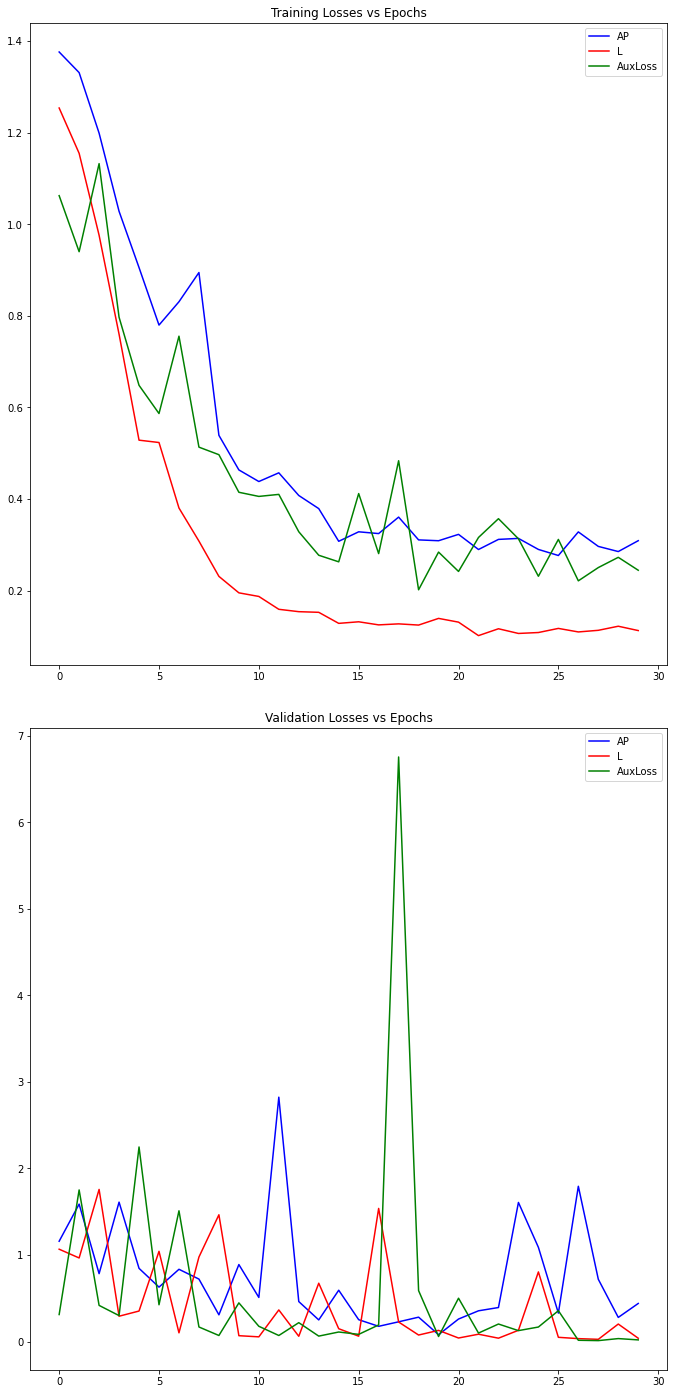

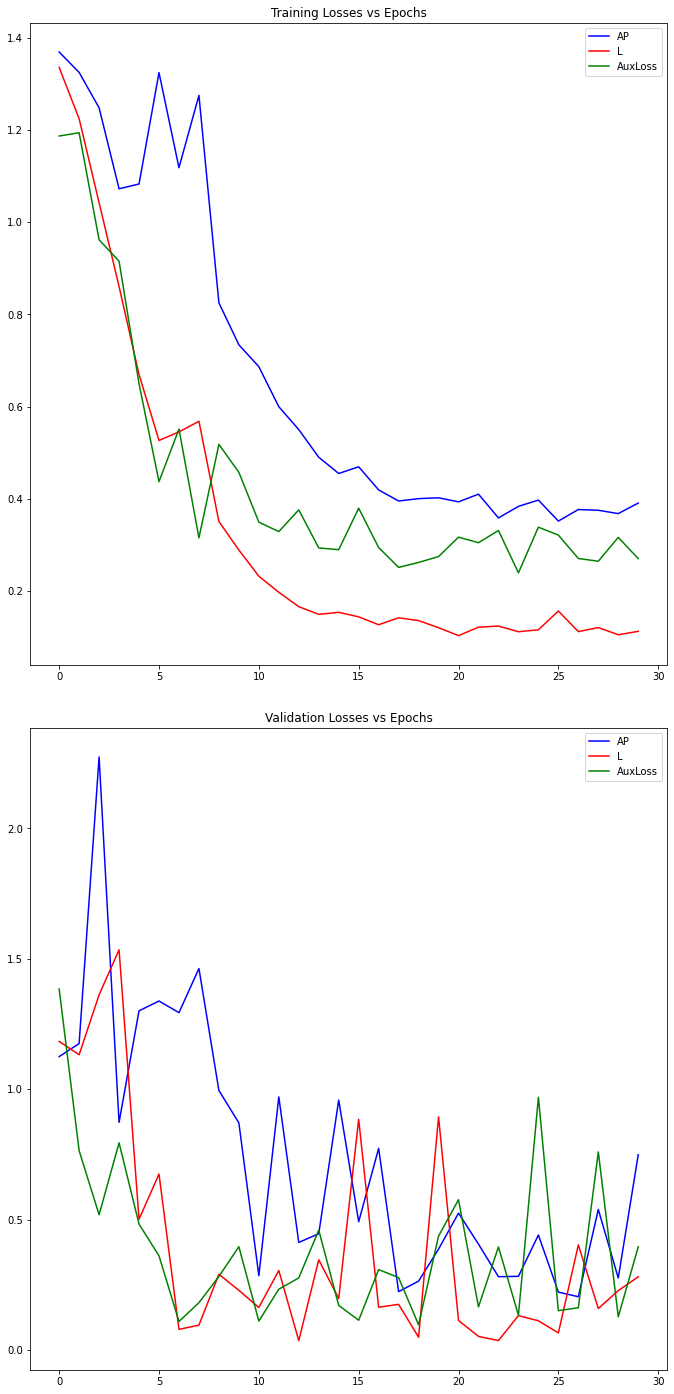

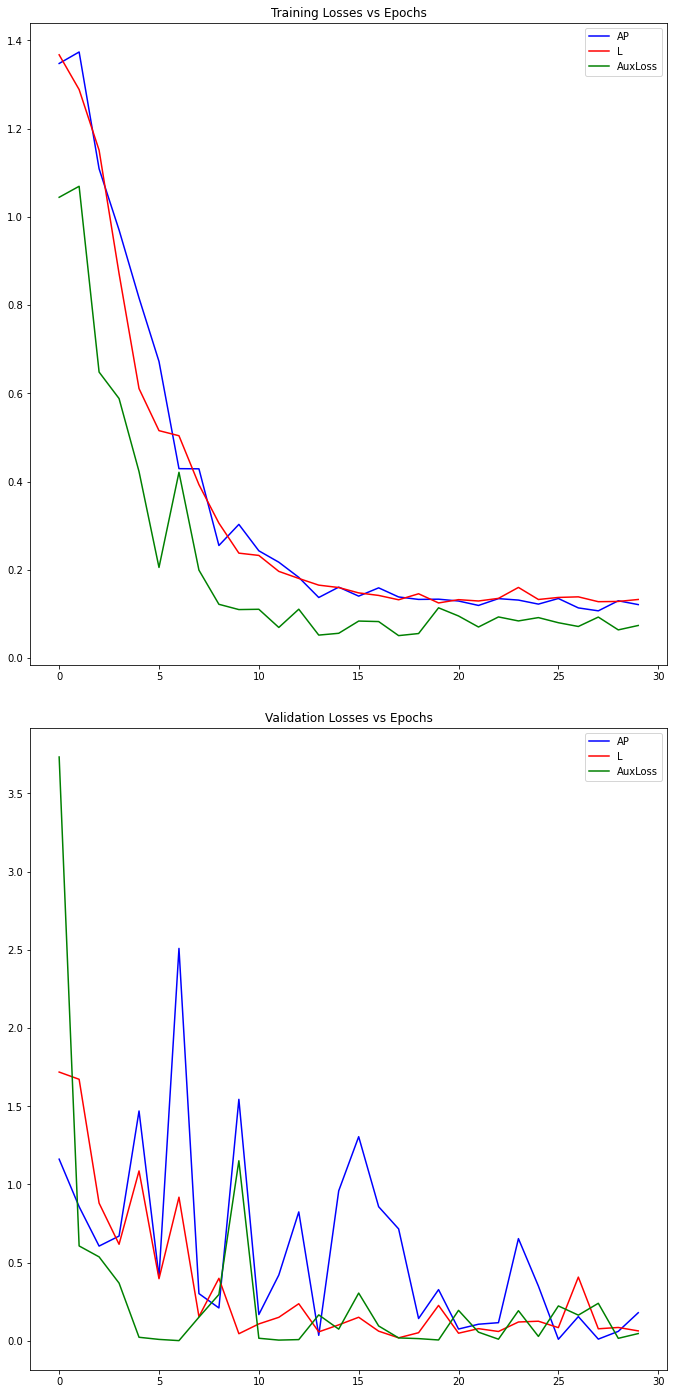

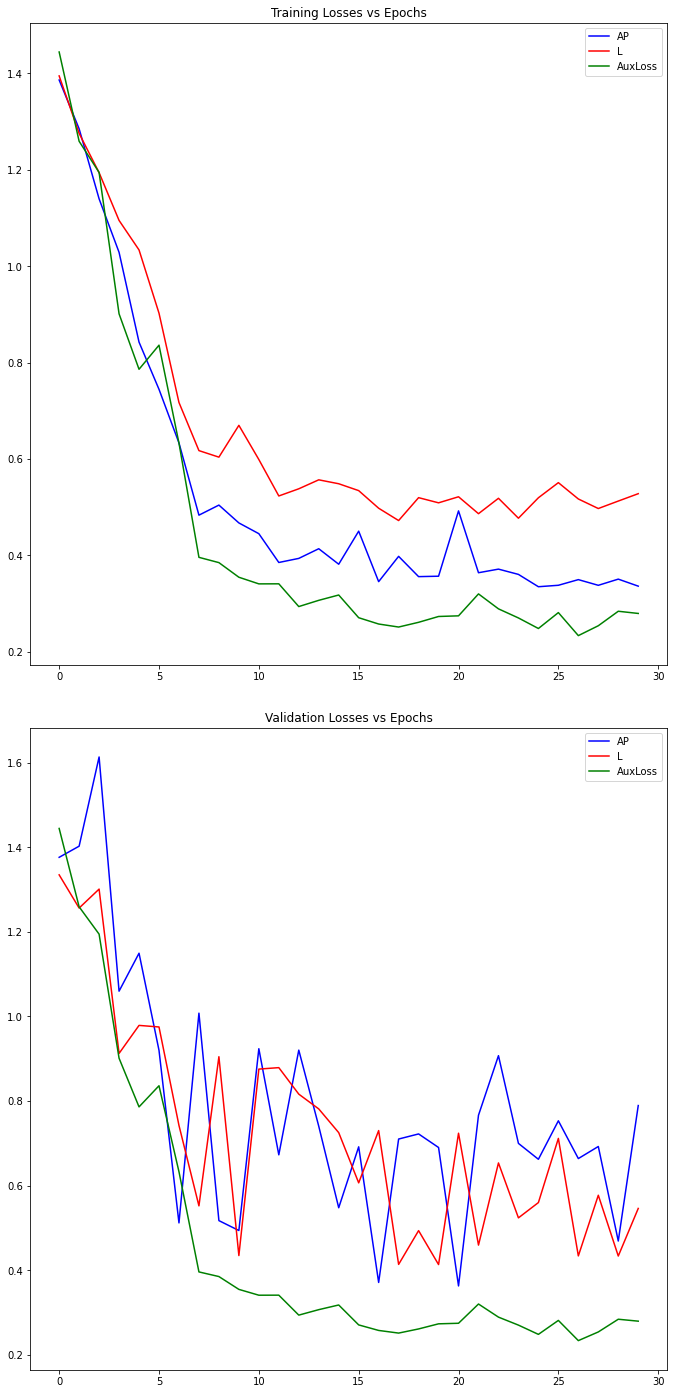

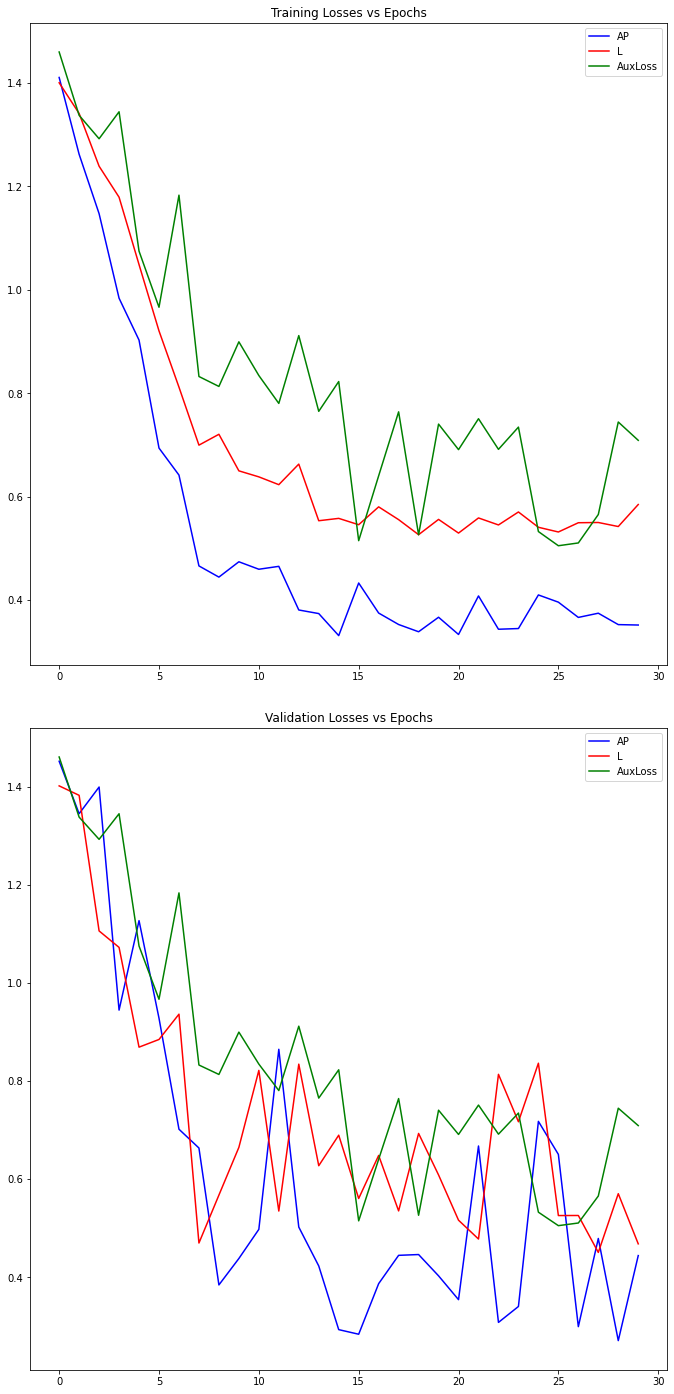

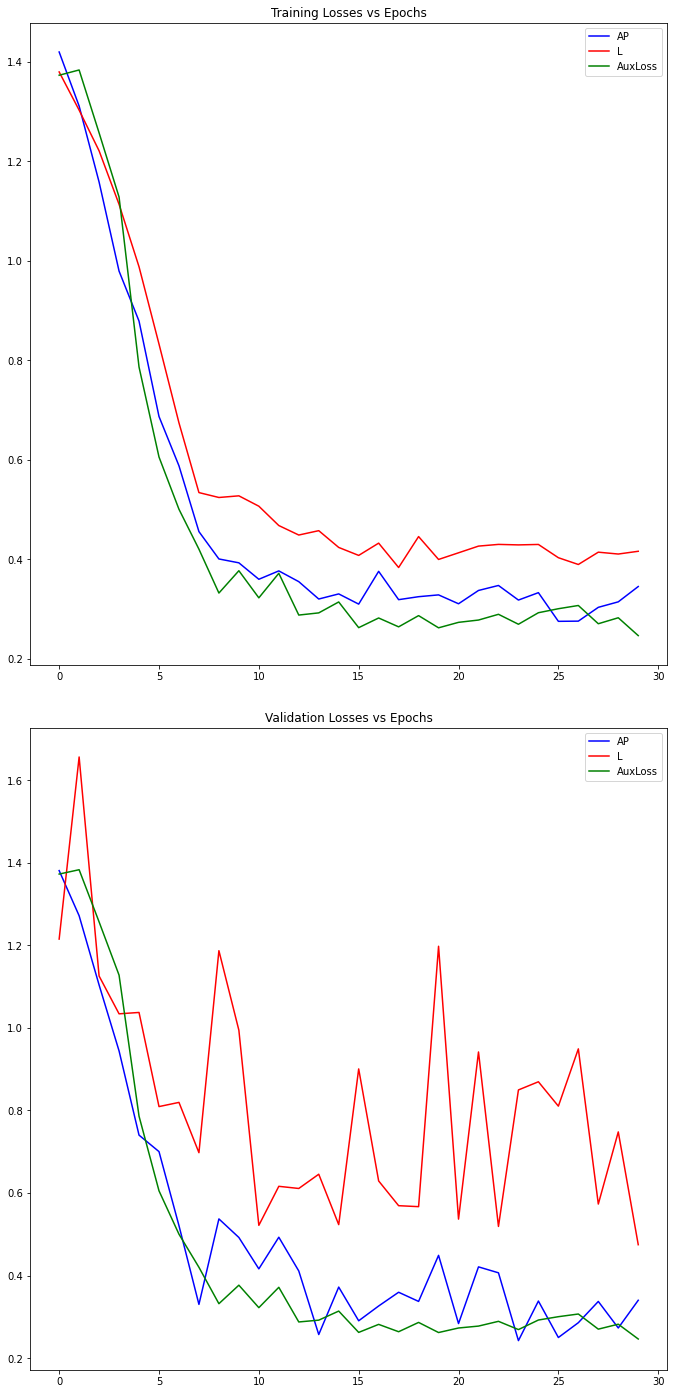

In [9]:
iterations = 1

# Augmented Anterior Models
A_best_f1 = 0
A_f1 = []
A_prec = []
A_rec = []
A_area = []
A_confusion = []

best_hyperparams = {'lr_L': 0.0002,
 'lr_AuxLoss': 8e-05,
 'lr_AP': 0.0006,
 'dropout_L': 0.2,
 'dropout_AuxLoss': 0.2,
 'dropout_AP': 0.2}

for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Anterior_HDW_MultiView.csv', augs=True)
    A_f1.append(f1_score)
    A_prec.append(precision)
    A_rec.append(recall)
    A_area.append(auc)
    A_confusion.append(confusion_matrix)
    if (f1_score > A_best_f1):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestAnteriorAugWeight.pth')
            A_best_f1 = f1_score

print(A_f1)
print(A_prec)
print(A_rec)
print(A_area)
print(A_confusion)

# Augmented Posterior Models
P_best_f1 = 0
P_f1 = []
P_prec = []
P_rec = []
P_area = []
P_confusion = []

for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Posterior_HDW_MultiView.csv', augs=True)
    P_f1.append(f1_score)
    P_prec.append(precision)
    P_rec.append(recall)
    P_area.append(auc)
    P_confusion.append(confusion_matrix)
    if (f1_score > P_best_f1):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestPosteriorAugWeight.pth')
        P_best_f1 = f1_score   

print(P_f1)
print(P_prec)
print(P_rec)
print(P_area)
print(P_confusion)

# Non-Augmented Anterior Models
A_best_f1_Naug = 0
A_f1_Naug = []
A_prec_Naug = []
A_rec_Naug = []
A_area_Naug = []
A_confusion_Naug = []

for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Anterior_HDW_MultiView.csv', augs=False)
    A_f1_Naug.append(f1_score)
    A_prec_Naug.append(precision)
    A_rec_Naug.append(recall)
    A_area_Naug.append(auc)
    A_confusion_Naug.append(confusion_matrix)
    if (f1_score > A_best_f1_Naug):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestAnteriorNAugWeight.pth')
            A_best_f1_Naug = f1_score

print(A_f1_Naug)
print(A_prec_Naug)
print(A_rec_Naug)
print(A_area_Naug)
print(A_confusion_Naug)
            
# Non-Augmented Posterior Models
P_best_f1_Naug = 0
P_f1_Naug = []
P_prec_Naug = []
P_rec_Naug = []
P_area_Naug = []
P_confusion_Naug = []

for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Posterior_HDW_MultiView.csv', augs=False)
    P_f1_Naug.append(f1_score)
    P_prec_Naug.append(precision)
    P_rec_Naug.append(recall)
    P_area_Naug.append(auc)
    P_confusion_Naug.append(confusion_matrix)
    if (f1_score > P_best_f1_Naug):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestPosteriorNAugWeight.pth')
            P_best_f1_Naug = f1_score

print(P_f1_Naug)
print(P_prec_Naug)
print(P_rec_Naug)
print(P_area_Naug)
print(P_confusion_Naug)

In [ ]:
# function to load and test a saved model
def test_saved_model(master_file, model_name):
    device = 'cuda:1' # use cuda 1 because it has more memory than cuda 0

    Train_Set, Val_Set, Test_Set = splitting.split_data(master_file, 'nonsense', return_data=True, save_data=False)

    # Taking the preprocessed images, need to change the filepath to point at the png area
    Train_Set['filepath_AP'] = Train_Set['filepath_AP'].str[:-4] + "_processed.png"
    Val_Set['filepath_AP'] = Val_Set['filepath_AP'].str[:-4] + "_processed.png"
    Test_Set['filepath_AP'] = Test_Set['filepath_AP'].str[:-4] + "_processed.png"
    Train_Set['filepath_L'] = Train_Set['filepath_L'].str[:-4] + "_processed.png"
    Val_Set['filepath_L'] = Val_Set['filepath_L'].str[:-4] + "_processed.png"
    Test_Set['filepath_L'] = Test_Set['filepath_L'].str[:-4] + "_processed.png"

    Train_Set['filepath_AP'] = '..' + Train_Set['filepath_AP'].str[16:]
    Val_Set['filepath_AP'] = '..' + Val_Set['filepath_AP'].str[16:]
    Test_Set['filepath_AP'] = '..' + Test_Set['filepath_AP'].str[16:]
    Train_Set['filepath_L'] = '..' + Train_Set['filepath_L'].str[16:]
    Val_Set['filepath_L'] = '..' + Val_Set['filepath_L'].str[16:]
    Test_Set['filepath_L'] = '..' + Test_Set['filepath_L'].str[16:]

    aug_wo_norm = augmentations.apply_augmentations_wo_norm(data_set="train", size_val=256, contrast_val=0.25, 
                                                        hue_val=0.25, grayscale_prob=0.1,
                                                        hflip_prob=0.5, degree_val=0, 
                                                        shear_val=1)
    # Creating train dataset
    train_dataset = ViewsDataset(Train_Set[['filepath_AP', 'filepath_L']], Train_Set['Label'], aug_wo_norm, png=True)

    # do augmentation based on entire dataset (instead of AP/L/AuxLoss sets individually)
    dataset_means, dataset_stds = get_training_mean_std(train_dataset)

    # Augmentation function with normalization
    param_aug = {'size_val': 256, 'contrast_val':0.25, 
             'hue_val': 0.25, 'grayscale_prob': 0.1,
             'hflip_prob': 0.5, 'degree_val':0,
             'shear_val':1, 'avg_pop_mean': dataset_means, 
             'avg_pop_std': dataset_stds
    }
    aug_functions = {x: augmentations.apply_augmentations_with_norm(data_set=x, **param_aug) for x in ['train', 'val', 'test']}

    params_test = {'batch_size': 1,
                  'shuffle': False,
                  'num_workers': 1}

    image_datasets_test = {
            'test': ViewsDataset(Test_Set[['filepath_AP', 'filepath_L']], Test_Set['Label'], augmentation_function= aug_functions['test'])
                    }

    dataloaders_test = {x: DataLoader(image_datasets_test[x], **params_test) for x in ['test']}

    # import DenseNet-121 models
    AP_model = models.densenet121(pretrained=True).to(device)
    L_model = models.densenet121(pretrained=True).to(device)

    num_classes = len(Train_Set['Label'].value_counts())

    AP_model.classifier = nn.Linear(in_features=1024, out_features = num_classes)
    L_model.classifier = nn.Linear(in_features=1024, out_features = num_classes)

    # instantiate model
    AuxLoss = AuxLossModel(AP_model, L_model, num_classes, 0.2).to(device)
    AuxLoss.load_state_dict(torch.load(model_name))
    pred_Aux, prob_Aux, label_Aux = evaluate_model(AuxLoss, dataloaders_test)
    f1_score, precision, recall, auc, confusion_matrix = metrics.metrics_function(pred_Aux, prob_Aux, label_Aux)

    display(f1_score)
    display(precision)
    display(recall)
    display(auc)
    display(confusion_matrix)
    return f1_score, precision, recall, auc, confusion_matrix

## Iterate over anterior dataset and augmented images with random hyperparameter search to tune hyperparameters

In [ ]:
iterations = 6
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(0)
param_grid = {'lr_AuxLoss':[8e-5, 2e-4, 6e-4],'lr_AP':[8e-5, 2e-4, 6e-4], 'lr_L': [8e-5, 2e-4, 6e-4], 
              'dropout_AuxLoss':[0.2, 0.3, 0.5], 'dropout_AP':[0, 0.1, 0.2], 'dropout_L':[0, 0.1, 0.2]}
param_list = list(ParameterSampler(param_grid, n_iter=iterations, random_state=rng))

# Augmented Anterior Models
A_best_f1 = 0
A_f1 = []
A_prec = []
A_rec = []
A_area = []
A_confusion = []


for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Anterior_HDW_MultiView.csv', param_list[i], augs=True)
    A_f1.append(f1_score)
    A_prec.append(precision)
    A_rec.append(recall)
    A_area.append(auc)
    A_confusion.append(confusion_matrix)
    if (f1_score > A_best_f1):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestAnteriorAugWeight.pth')
            A_best_f1 = f1_score
            A_best_params = param_list[i]

print(A_f1)
print(A_prec)
print(A_rec)
print(A_area)
print(A_confusion)
print(A_best_params)

## Train and test model three times on each dataset with best hyperparameters on random train-val-test splits

In [ ]:
iterations = 3

# Augmented Anterior Models
A_best_f1 = 0
A_f1 = []
A_prec = []
A_rec = []
A_area = []
A_confusion = []

best_hyperparams = {'lr_L': 0.0002,
 'lr_AuxLoss': 8e-05,
 'lr_AP': 0.0006,
 'dropout_L': 0.2,
 'dropout_AuxLoss': 0.2,
 'dropout_AP': 0.2}

for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Anterior_HDW_MultiView.csv', best_hyperparams, augs=True)
    A_f1.append(f1_score)
    A_prec.append(precision)
    A_rec.append(recall)
    A_area.append(auc)
    A_confusion.append(confusion_matrix)
    if (f1_score > A_best_f1):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestAnteriorAugWeight.pth')
            A_best_f1 = f1_score

print(A_f1)
print(A_prec)
print(A_rec)
print(A_area)
print(A_confusion)

# Augmented Posterior Models
P_best_f1 = 0
P_f1 = []
P_prec = []
P_rec = []
P_area = []
P_confusion = []

for i in range(iterations):
    AuxLoss, f1_score, precision, recall, auc, confusion_matrix = create_train_test('../Master_Posterior_HDW_MultiView.csv', best_hyperparams, augs=True)
    P_f1.append(f1_score)
    P_prec.append(precision)
    P_rec.append(recall)
    P_area.append(auc)
    P_confusion.append(confusion_matrix)
    if (f1_score > P_best_f1):
#             torch.save(AuxLoss.state_dict(), './AuxLossBestPosteriorAugWeight.pth')
        P_best_f1 = f1_score   

print(P_f1)
print(P_prec)
print(P_rec)
print(P_area)
print(P_confusion)

## Generate Statistical Significance of Iterated Results

Anterior dataset

In [2]:
f1s = [0.7165346594757627, 0.7204863056200757, 0.7509052200495403]
prec = [0.7912327023267874, 0.7093788564376798, 0.7516053397831609]
recall = [0.7840236686390533, 0.7427884615384616, 0.7552447552447552]
auc = [0.9081385250724423, 0.8551757124720702, 0.8719096150957376]
metrics.compile_numeric_results(f1s, prec, recall, auc)

,Mean,Confidence Intervals,Support
F1,0.729309,"(0.6825890903113129, 0.7760283664522728)",3
Precision,0.750739,"(0.6490537701658892, 0.8524241621991961)",3
Recall,0.760686,"(0.7081481477163916, 0.8132231092317885)",3
AUC,0.878408,"(0.811155403227752, 0.9456604985324147)",3


Posterior dataset

In [3]:
f1s = [0.39482102056359486, 0.4489850427350427, 0.3333333333333333]
prec = [0.3067455621301775, 0.40934065934065933, 0.25]
recall = [0.5538461538461539, 0.5, 0.5]
auc = [0.6085700689004717, 0.5022891267419312, 0.421202952690428]
metrics.compile_numeric_results(f1s, prec, recall, auc)

,Mean,Confidence Intervals,Support
F1,0.392380,"(0.24863643834924404, 0.5361231594054032)",3
Precision,0.322029,"(0.12140415788580566, 0.5226533230947521)",3
Recall,0.517949,"(0.4407216176682592, 0.5951758182291769)",3
AUC,0.510687,"(0.27726424771973573, 0.7441105178354848)",3
